# 2005 UD Polarimetric Phase Curve Fitting, with Devogele+2020 (2020PSJ.....1...15D)

The data from Devogele is revised by Jooyeon Geem after retrieving the original FITS data (2021 Jan).

In the cell below, ``dats_devogele`` is updated by 
1. Remove the 0-th row (α=87.71˚ data)
2. Insert the following
    ```
    alpha, Pr, err
    87.4, 41.35, 2.86
    106.47,54.33, 6.57
    ```

The issue is that the data is contaminated by field stars (∵ the original data has no polarization mask, so the ordinary and extraordinary rays overlap within the FOV). Jooyeon Geem manually removed such "strongly contaminated" data, and utilized only **2 sets** for 87.4˚ and **1 set** for 106.47˚ for the P_r calculation.

As a part of the publication of IshiguroM+ 2021 (in prep), here I provide full of the analysis code.

## 1. Installation

### 1-1. pymc3
On terminal (Anaconda Prompt or Git Bash on windows)
```
$ conda install pymc3 theano=1.0.4 -c conda-forge
```
See the [issue here](https://github.com/pymc-devs/pymc3/issues/3340) if you encounter problems afterwards.

## 2. Explaining Packages Used
In the code below, I used ``pymc3`` and ``scipy.optimize.curve_fit`` for the fitting algorithm. Let me briefly explain these things here.

### 2-1. ``pymc3``
The package I used for the MCMC simulation is the [``pymc3`` package](https://docs.pymc.io). Its usage is very complicated in my opinion. There are few things to keep in mind:

1. Unlike most python packages, you should work with the ``pymc3.model`` object by using the ``with`` block:
```python
basic_model = pm.Model()
with basic_model:
    # <contents goes here>
```
2. Math functions, e.g., sin/cos/exp, etc, should be used from ``pymc3.math``, not ``numpy``. You must import by ``from pymc3.math import sin, cos`` and use something like ``sin(x)`` and ``cos(x)`` inside the ``with`` block above.
3. ``pymc3`` uses ``theano``. Although it makes the calculation much faster (they argue), but it gets a bit more complicated for those who are not familiar with ``theano``. I here used it to add error-bars to data points, and you may find more examples by Googling.

### 2-2. ``scipy``'s ``curve_fit``
In the ``curve_fit`` function I used below, I tested (1) set the bounds to the parameters and (2) let them be unbounded. 

The Levenberg-Marquadt least square algorithm should not be used to bounded problem. Thus, scipy uses the _trusted region reflective_ (``trf``) algorithm. 

The explanation and implementation of it:
1. See [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares) of scipy  
2. The scipy version we used here is 1.5.2, and the ``trf`` is implemented by [``trf.py`` (GitHub link)](https://github.com/scipy/scipy/blob/v1.2.1/scipy/optimize/_lsq/trf.py). The docstring explains the implementation.

Basically it is similar to [MINPACK of FORTRAN](https://en.wikipedia.org/wiki/MINPACK), the documentation says.

### 2-3. Versions I used

In [1]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information scipy, numpy, matplotlib, pandas, numba, pymc3, theano, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2021-01-29 18:34:55 (KST = GMT+0900) 
0 Python     3.8.5 64bit [Clang 10.0.0 ]
1 IPython    7.19.0
2 OS         macOS 10.14.6 x86_64 i386 64bit
3 scipy      1.5.2
4 numpy      1.19.2
5 matplotlib 3.3.2
6 pandas     1.2.1
7 numba      0.51.2
8 pymc3      3.8
9 theano     1.0.4
10 version_information 1.0.3


**NOTE**: For the parameter correlations plot, I used [``corner``](https://github.com/dfm/corner.py) package.

## 3. Basic Setup

### 3-1. Import
Import necesary things:

In [2]:
%config InlineBackend.figure_format = 'retina'
InteractiveShell.ast_node_interactivity = 'last_expr'

In [3]:
from pathlib import Path

import numpy as np
import numba as nb
import pandas as pd
import pymc3 as pm
from pymc3.math import sin, cos
import theano
import corner

from astropy.io.ascii.latex import latexdicts
from astropy.table import Table, vstack

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

from scipy.optimize import curve_fit
from scipy.stats import chi2

np.random.seed(12345)
plt.style.use('default')
rcParams.update({'font.size':12})
errbfmt = dict(marker='x', capsize=3, elinewidth=0.5, ls='')

### 3-2. Define
Define some things:

In [4]:
D2R = np.pi / 180
DATAPATH = Path('data')
SAVEPATH = Path('figs')

@nb.njit#(parallel=True)
def cos_deg(x):
    return np.cos(x * D2R)


@nb.njit#(parallel=True)
def sin_deg(x):
    return np.sin(x * D2R)


def trigp_purepython(x, h, c1, c2, a0):
    ''' Lumme-Muinonen function in pure python mode.
    '''
    term1 = (sin_deg(x) / sin_deg(a0))**c1
    term2 = (cos_deg(x / 2) / cos_deg(a0 / 2))**c2
    term3 = sin_deg(x - a0)
    Pr = h / D2R * term1 * term2 * term3
    return Pr

@nb.njit#(parallel=True)
def trigp(x, h, c1, c2, a0):
    ''' Lumme-Muinonen function in numba mode.
    '''
    term1 = (sin_deg(x) / sin_deg(a0))**c1
    term2 = (cos_deg(x / 2) / cos_deg(a0 / 2))**c2
    term3 = sin_deg(x - a0)
    Pr = h / D2R * term1 * term2 * term3
    return Pr


@nb.njit(parallel=True)
def do_trigp(x, y, yerr, arr_h, arr_c1, arr_c2, arr_a0, arr_chi2, arr_amax,
             arr_Pmax, arr_amin, arr_Pmin):
    ''' To calculate everything needed for the analysis.
    Parameters
    ----------
    x, y, yerr : array-like
        The phase angle [˚], Pr [%], and err_Pr [%].
    arr_h, arr_c1, arr_c2, arr_a0 : array-like
        The ``trace``d arrays of the four parameters of Lumme-Muinonen function
        from pymc3.
    arr_chi2, arr_amax, arr_Pmax, arr_amin, arr_Pmin : array-like
        The empty arrays of chi-square, min/max phase angle (``a``)
        and the polarization degree (``P``). Must have the same length as
        the arrays given above. (It will not give error if these are longer
        than the above ones, but...)
    '''
    xx_min = np.arange(2, 15, 0.01)
    xx_max = np.arange(80, 140, 0.01)

    for i in nb.prange(arr_h.shape[0]):
        h = arr_h[i]
        c1 = arr_c1[i]
        c2 = arr_c2[i]
        a0 = arr_a0[i]
        resid = y - trigp(x, h=h, c1=c1, c2=c2, a0=a0)
        chi2 = np.sum((resid / yerr)**2)
        amax, Pmax = trigp_max(xx_max, h=h, c1=c1, c2=c2, a0=a0)
        amin, Pmin = trigp_min(xx_min, h=h, c1=c1, c2=c2, a0=a0)

        arr_chi2[i] = chi2
        arr_amax[i] = amax
        arr_Pmax[i] = Pmax
        arr_amin[i] = amin
        arr_Pmin[i] = Pmin


@nb.njit#(parallel=True)
def trigp_min(xx, h, c1, c2, a0):
    """ Calculates the minimum phase angle/P degree from given parameters.
    """
    minimum = 1
    for i in range(xx.shape[0]):
        p = trigp(xx[i], h, c1, c2, a0)
        if p < minimum:
            minimum = p
        else:
            break
    return (xx[i - 1], minimum)


@nb.njit#(parallel=True)
def trigp_max(xx, h, c1, c2, a0):
    """ Calculates the maximum phase angle/P degree from given parameters.
    """
    maximum = -1
    for i in range(xx.shape[0]):
        p = trigp(xx[i], h, c1, c2, a0)
        if p > maximum:
            maximum = p
        else:
            break
    return (xx[i - 1], maximum)

### 3-3. Data
Now, load data and see if loaded correctly:

In [5]:
from io import StringIO
data = StringIO('''PA Pr err_Pr
68.1 23.24 3.58
63.62 20.48 1.14
55.45 12.45 1.55
33.5 4.24 0.18
29.29 2.48 0.08
25.47 1.54 0.07
11.67 -0.79 0.09
8.66 -1.25 0.07''')
# 46.41 7.97 12.16 is removed

dats = pd.read_csv(data, sep=' ')
dats

,PA,Pr,err_Pr
0,68.10,23.24,3.58
1,63.62,20.48,1.14
2,55.45,12.45,1.55
3,33.50,4.24,0.18
4,29.29,2.48,0.08
5,25.47,1.54,0.07
6,11.67,-0.79,0.09
7,8.66,-1.25,0.07


In [6]:
# Add the following:
data2add = StringIO('''PA Pr err_Pr
87.4 41.35 2.86
106.47 54.33 6.57''')
data2add = pd.read_csv(data2add, sep=' ')

dats_devogele = pd.read_csv(DATAPATH/"2020PSJ.....1...15D.csv", sep=',')
dats_devogele = dats_devogele.drop(0)
dats_devogele = pd.concat([dats_devogele, data2add])
dats_devogele = dats_devogele.reset_index(drop=True)
dats_devogele

,UT Date,JD,V,PA,ro,rh,Pr,err_Pr,Facility
0,2018-09-29,2.458392e+06,16.2,44.03,0.22,1.13,8.73,0.30,NOT
1,2018-09-30,2.458393e+06,16.2,39.52,0.22,1.15,6.23,0.06,NOT
2,2018-10-01,2.458394e+06,16.1,35.73,0.23,1.16,5.03,0.06,NOT
3,2018-10-02,2.458394e+06,16.0,32.51,0.23,1.18,3.62,0.07,Rozhen
4,2018-10-02,2.458394e+06,16.0,32.46,0.23,1.18,4.04,0.08,Rozhen
...,...,...,...,...,...,...,...,...,...
43,2018-10-14,2.458406e+06,15.9,2.25,0.25,1.23,-0.44,0.07,NOT
44,2018-10-15,2.458407e+06,16.2,4.18,0.25,1.23,-0.95,0.06,NOT
45,2018-10-17,2.458409e+06,16.6,7.83,0.25,1.23,-1.11,0.05,NOT
46,NaN,NaN,NaN,87.40,NaN,NaN,41.35,2.86,NaN


In [7]:
dats = pd.concat([dats, dats_devogele[["PA", "Pr", "err_Pr"]]])

If you have saved your data to the ``DATAPATH`` directory (relative path to where this notebook is located), you can use
```python
dats = pd.read_csv(DATAPATH / "weighted_avg.csv", sep=' ')
dats
```

## 4. Fit the Data! (Positive Power : _Bound_ Case)

There are 3 ways to get the fitted parameters, and I used two different approaches to get the uncertainties.

1. The first is a simple **least square fit** by Levenberg-Marquadt algorithm (more rigorously speaking, a bounded version of it, which is called ``trf`` in ``scipy`` (explained above in Sect. 2-2.). It is possible to obtain the covariance matrix, but I did **not** use it for the error analysis.

2. The second is an **MCMC** approach, which is almost fully automatical by ``PyMC3``. I only tuned the number of samples. The MCMC sample mean and standard deviations are the estimation of the parameter and its standard error (1-σ confidence).

3. The last is the **chi-square method**. The best fit paramters are identical to the least square fit. I used the MCMC samples to define the boundaries of the 1-σ contour in the N-D parameter space; that is, I calculated the chi-square for all the MCMC samples (parameter pair), and find the min/max of each parameter which gave small enough chi-square (see below).

In the main part of the publication, we only used the second result for brevity.

Also, for the Lumme-Muinonen function to make sense, the parameters c1/c2 must be positive. But if we do so, the MCMC trace show a truncated posterior (see below), so I tested without requiring c1/c2 to be positive. This is shown in the next section of this note.

### 4-1. Crude Scipy Fit

Before going to MCMC which will take some time and initial guess of the parameters, I here show a simple ``trf`` algorithm by scipy, which is a crude "bounded" version of Levenberg-Marquadt algorithm.

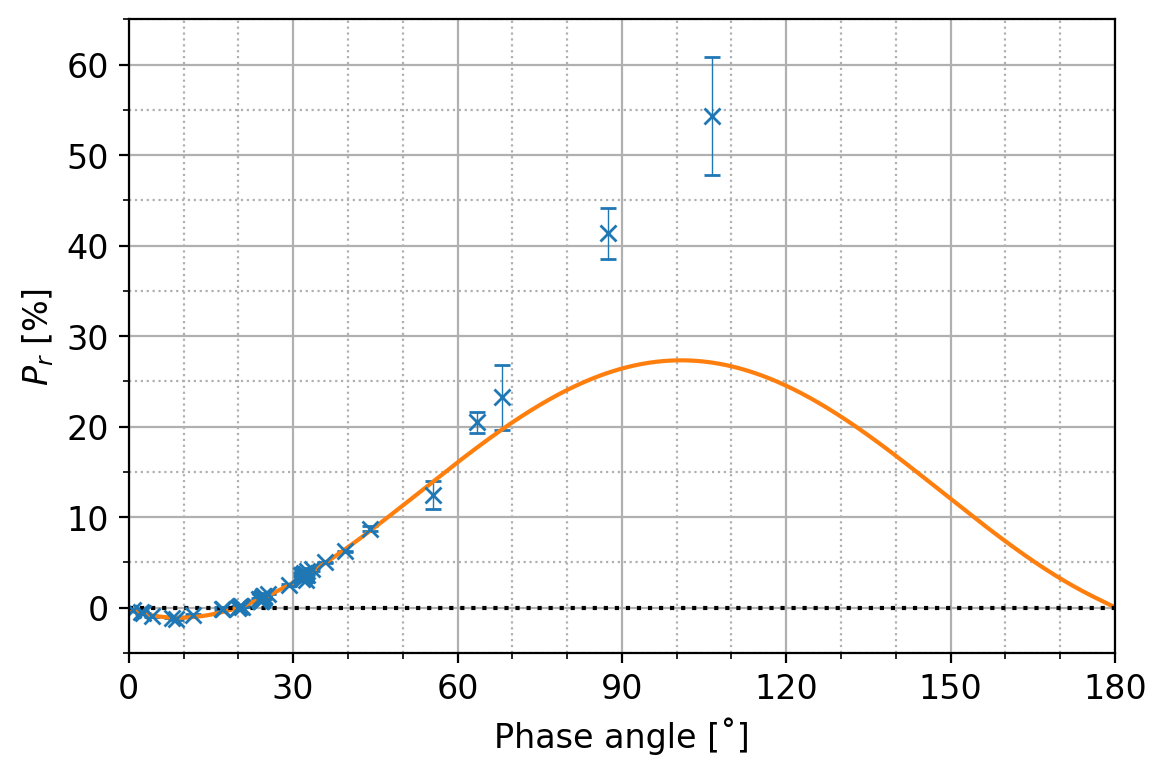

In [8]:
x, y, yerr = dats["PA"].to_numpy(), dats["Pr"].to_numpy(), dats["err_Pr"].to_numpy()
x_rad = D2R * x
xx = np.arange(0.1, 180, 0.1)

popt, pcov = curve_fit(trigp_purepython, x, y, sigma=yerr, p0=[1, 1, 1, 20],
                       absolute_sigma=True,
                       bounds=((0.01, 1.e-4, 1.e-4, 10),
                               (10.0, 10.0, 10.0, 30)))

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4), sharex=False, sharey=False, gridspec_kw=None)

majloc = [MultipleLocator(30), MultipleLocator(10)]
minloc = [MultipleLocator(10), MultipleLocator(5)]
majfmt = [FormatStrFormatter("%d"), FormatStrFormatter("%d")]

ax1 = plt.subplot(1, 1, 1)
ax1.errorbar(x, y, yerr, **errbfmt)
ax1.plot(xx, trigp_purepython(xx, *popt))

ax1.set_xlabel("Phase angle [˚]")
ax1.set_ylabel(r"$ P_r $ [%]")
ax1.set_xlim(0, 180)
ax1.set_ylim(-5, 65)
ax1.axhline(0, color='k', ls=':')

for i, aa in enumerate([ax1.xaxis, ax1.yaxis]):
    aa.set_major_locator(majloc[i])
    aa.set_minor_locator(minloc[i])
    aa.set_major_formatter(majfmt[i])
ax1.grid(which='major', ls='-')
ax1.grid(which='minor', ls=':')
plt.tight_layout()

plt.savefig(SAVEPATH / "with-Devogele-revised-observation-fit.png")
plt.savefig(SAVEPATH / "with-Devogele-revised-observation-fit.pdf");

Simple least-square fit will give the following best-fit parameters with the diagonal components as the variance of parameters when the $\chi^2$ contour are N-D ellipse (which is not used for error analysis):

In [9]:
popt, pcov = curve_fit(trigp_purepython, x, y, sigma=yerr, 
                       p0=[1, 1, 1, 20],
                       absolute_sigma=True,
                       bounds=((0.01, 1.e-4, 1.e-4, 10),
                               (10.0, 10.0, 10.0, 30)))

print("Least Square Fit with Scipy curve_fit\n")
print("h[%/˚]  c1      c2      a0[˚]")
print(f"{popt[0]:.4f}  {popt[1]:.4f}  {popt[2]:.4f}  {popt[3]:.4f}\n")

print("Elliptical Approximation Errors of above")
print("{:.4f}  {:.4f}  {:.4f}  {:.4f}\n".format(*np.sqrt(np.diag(pcov))))

amin, Pmin = trigp_min(np.arange(0, 20, 0.01), *popt)
amax, Pmax = trigp_max(np.arange(80, 130, 0.01), *popt)
print("amin[˚]  Pmin[%]  amax[˚]  Pmax[%]")
print(f"{amin:.2f}     {Pmin:.2f}    {amax:.2f} {Pmax:.2f}")

Least Square Fit with Scipy curve_fit

h[%/˚]  c1      c2      a0[˚]
0.1986  0.8376  0.0001  19.8766

Elliptical Approximation Errors of above
0.0026  0.0195  0.2762  0.0907

amin[˚]  Pmin[%]  amax[˚]  Pmax[%]
9.08     -1.12    100.80 27.33


### 4-2. MCMC with ``pymc3``
Now that we got some clue about the initial parameters, do MCMC.

I assume all the parameters follow **uniform prior**, but only the lower/upper bounds of the parameters are subjectively set. 

**HERE I AM ASSUMING THE POWER PARAMETERS (C1 AND C2) ARE POSITIVE**. For non-bounded case, see section 5.

Run pymc3 for MCMC simulation:

In [10]:
basic_model = pm.Model()
with basic_model:
    h = pm.Uniform('h', 0, 1)
    a0 = pm.Uniform('a0', 10, 35)
    c1 = pm.Uniform('c1', 1.e-4, 3)
    c2 = pm.Uniform('c2', 1.e-4, 3)
#     c2 = pm.HalfNormal('c2', 0.1)

    sigma = theano.shared(np.asarray(yerr, dtype=theano.config.floatX), name='sigma')

    Y_hat = (h / D2R 
             * (sin(x * D2R) / sin(a0 * D2R))**c1 
             * (cos(x * D2R / 2) / cos(a0 * D2R / 2))**c2 
             * sin( (x - a0) * D2R)
            )
    liklihood = pm.Normal('likelihood', mu=Y_hat, sd=sigma, observed=y)

    trace = pm.sample(20000, start=dict(h=0.1, a0=20, c1=0.1, c2=1.e-3))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c2, c1, a0, h]
Sampling 4 chains, 0 divergences: 100%|██████████| 82000/82000 [00:48<00:00, 1679.21draws/s]
The acceptance probability does not match the target. It is 0.8878368224543088, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8796761299413031, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8903706996629125, but should be close to 0.8. Try to increase the number of tuning steps.


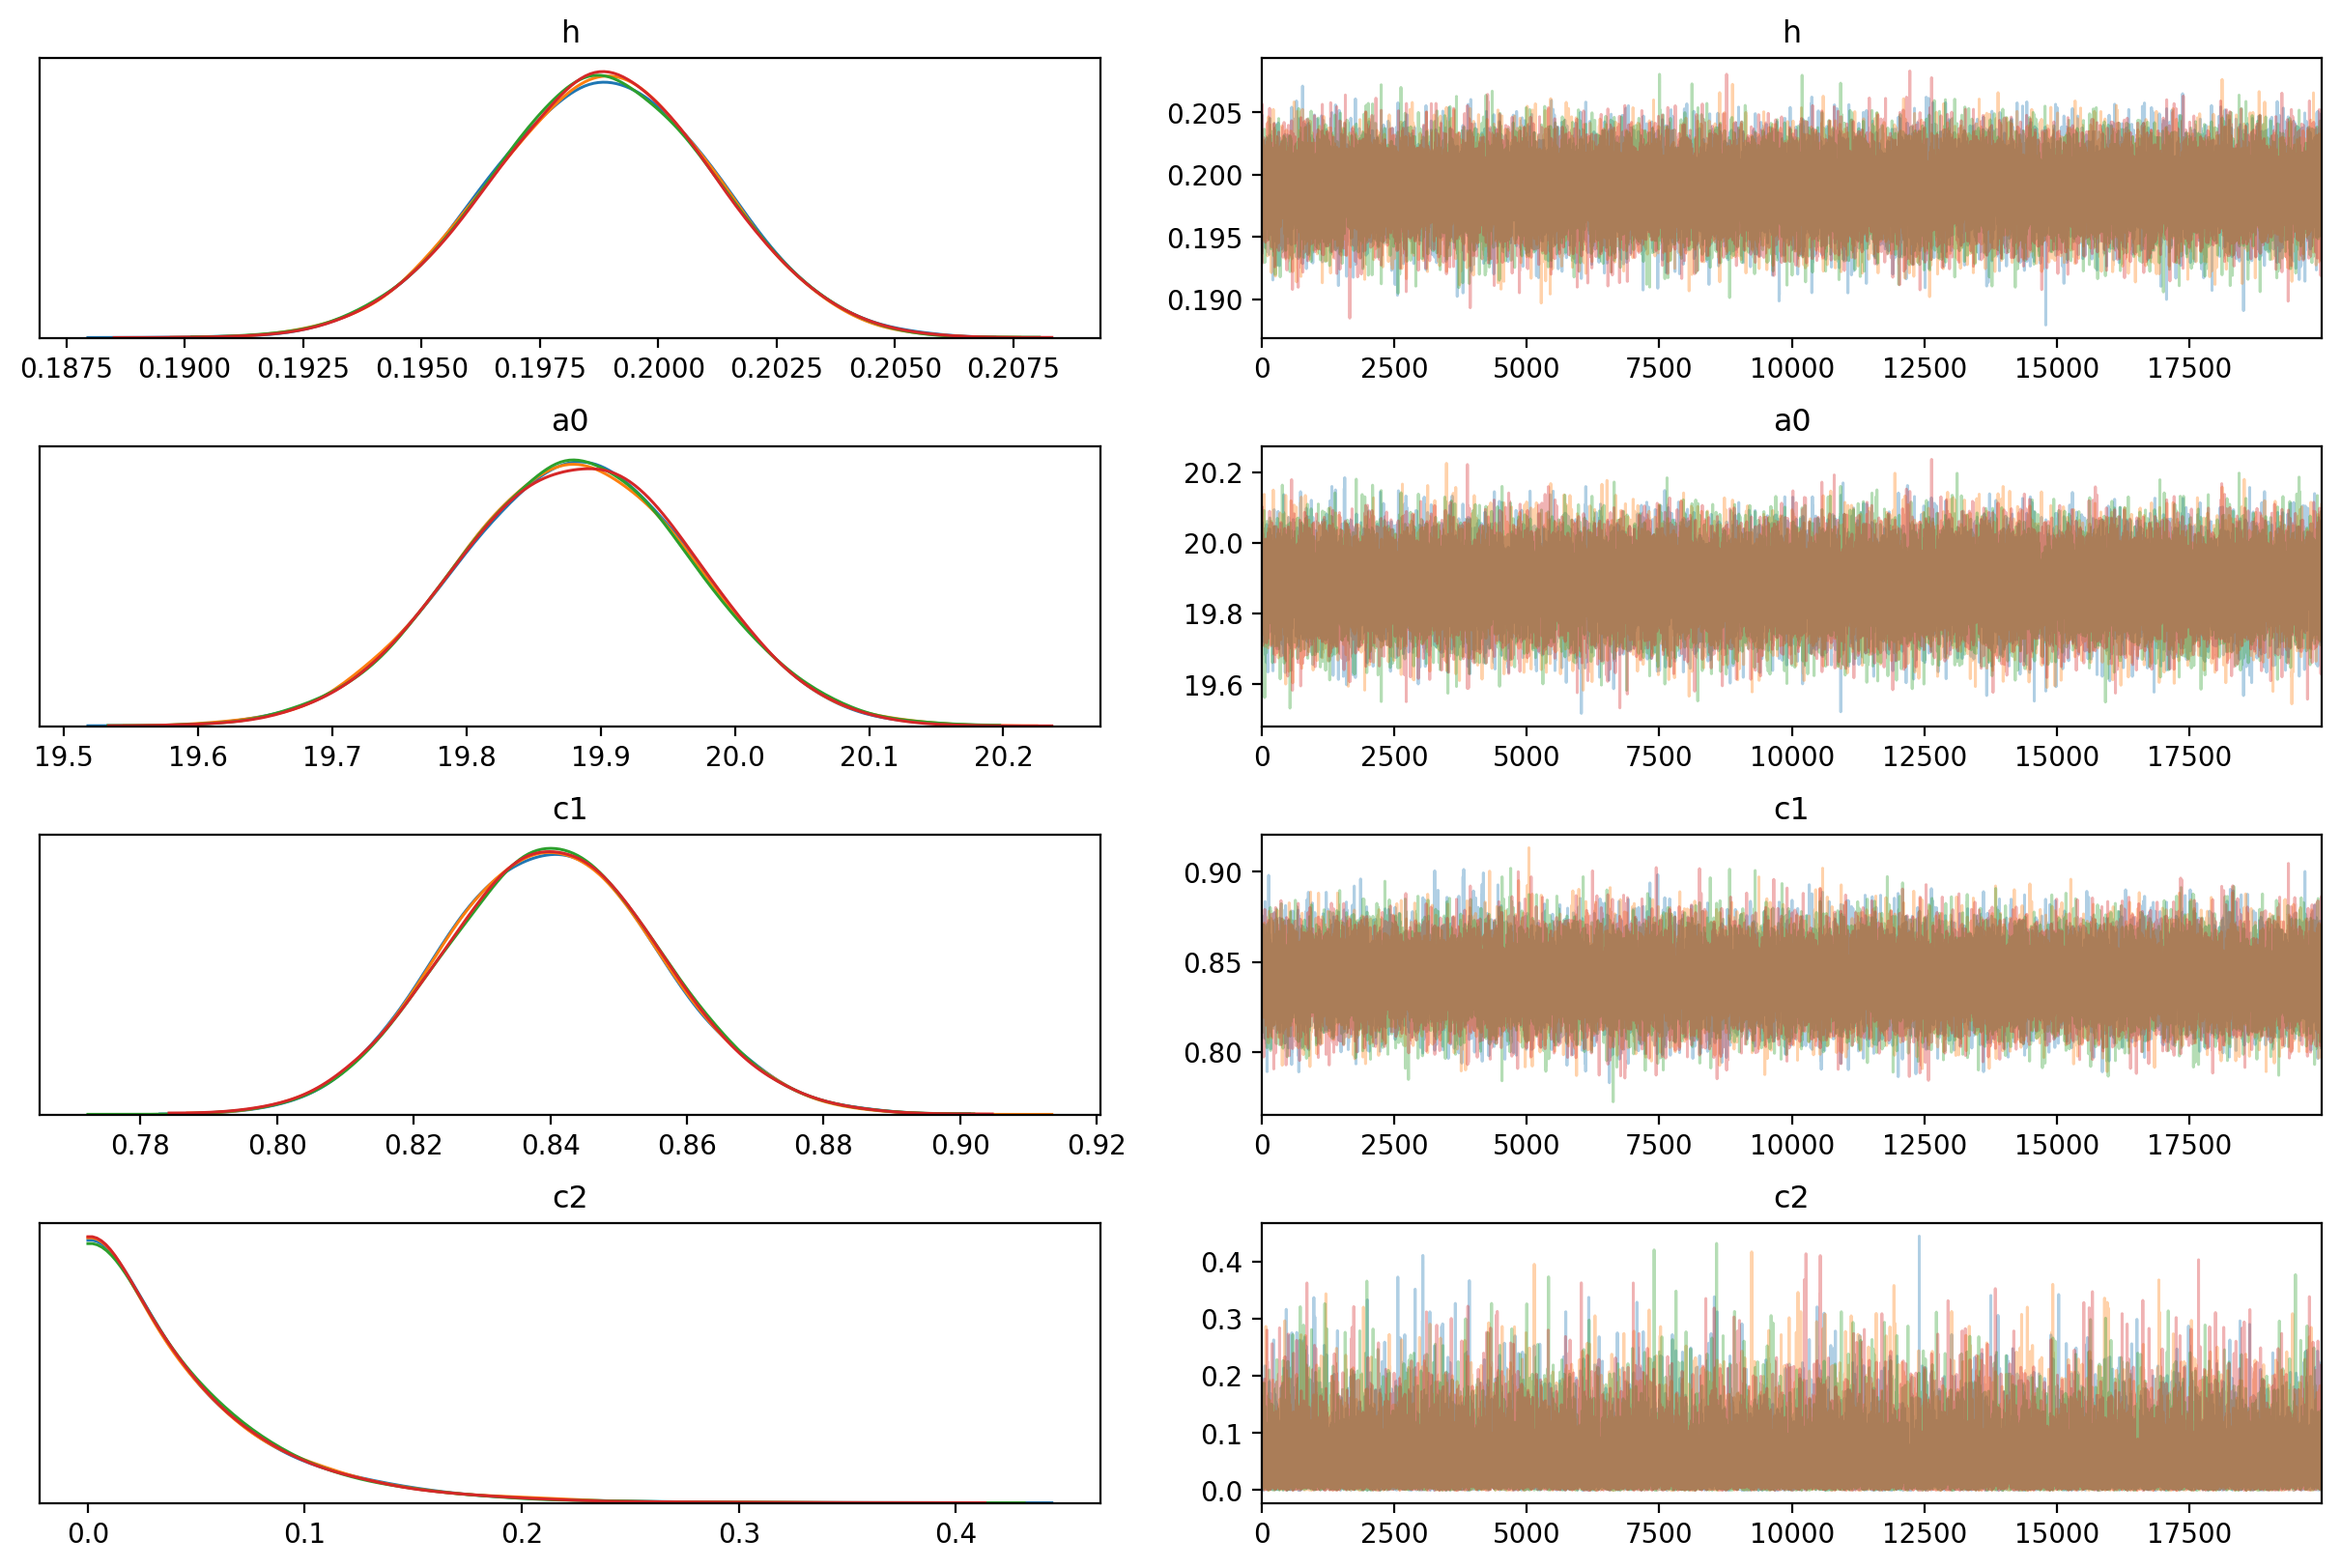

In [11]:
pm.traceplot(trace)
plt.savefig(SAVEPATH / "with-Devogele-revised-trace.png", dpi=300)
plt.savefig(SAVEPATH / "with-Devogele-revised-trace.pdf");

As can be seen, the trace looks very good except for c2. (see [here](https://support.sas.com/documentation/cdl/en/statug/63033/HTML/default/viewer.htm#statug_introbayes_sect008.htm#statug.introbayes.bayesvisual))

The trace plot shows the "trace" of the Monte Carlo traces of the parameter space. Below I show the hpd (Highest Posterior Density) intervals for 1- and 3-sigma level are shown. 

In Bayesian sense, the posterior mean and standard deviation are used as parameter estimation and estimation error (e.g., see [here](https://support.sas.com/documentation/cdl/en/statug/63033/HTML/default/viewer.htm#statug_introbayes_sect005.htm#statug.introbayes.bayesinterval)), while ``mc_error`` can be understood as an uncertainty intrinsic to this simulation due to the finite number of simulations (defined as ``sd/n_eff``). This should never be understood of the parameter uncertainty.

In [12]:
pm.summary(trace, credible_interval=0.6827).round(5)

,mean,sd,hpd_15.865%,hpd_84.135%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
h,0.199,0.002,0.196,0.201,0.0,0.0,40306.0,40306.0,40328.0,42663.0,1.0
a0,19.880,0.087,19.794,19.968,0.0,0.0,43182.0,43182.0,43192.0,44182.0,1.0
c1,0.840,0.016,0.824,0.856,0.0,0.0,44944.0,44896.0,44996.0,43811.0,1.0
c2,0.047,0.046,0.000,0.054,0.0,0.0,62283.0,58861.0,44244.0,30674.0,1.0


In summary, $ h = 0.199 \pm 0.002 \,[\%/^\circ] $ etc, for $ \mathrm{mean \pm std} $ notation.

In [13]:
pm.summary(trace, credible_interval=0.9973).round(5)  # 3-sigma

,mean,sd,hpd_0.135%,hpd_99.865%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
h,0.199,0.002,0.192,0.206,0.0,0.0,40306.0,40306.0,40328.0,42663.0,1.0
a0,19.880,0.087,19.620,20.141,0.0,0.0,43182.0,43182.0,43192.0,44182.0,1.0
c1,0.840,0.016,0.795,0.888,0.0,0.0,44944.0,44896.0,44996.0,43811.0,1.0
c2,0.047,0.046,0.000,0.269,0.0,0.0,62283.0,58861.0,44244.0,30674.0,1.0


In [14]:
res = []
for h, a0, c1, c2 in zip(trace.get_values('h'),
                         trace.get_values('a0'),
                         trace.get_values('c1'),
                         trace.get_values('c2')):
    res.append(trigp_min(xx, h, c1, c2, a0))
res = np.array(res)
amin_mean, pmin_mean = np.mean(res, axis=0)
amin_sd, pmin_sd = np.std(res, axis=0, ddof=1)
print(f"a_min = {amin_mean:.4f} ± {amin_sd:.4f}")
print(f"P_min = {pmin_mean:.4f} ± {pmin_sd:.4f}")

a_min = 9.0903 ± 0.1092
P_min = -1.1207 ± 0.0243


### 4-3. Chi-Square Analysis
In the chi-square sense, what we have to do are
1. Calculate the chi-square statistic at each parameter space position. 
2. Keep only those with $\chi^2 < \chi^2_\mathrm{min} + \Delta(\nu, \alpha)$ 
    * $\Delta$: inverse cdf (cumulative distribution function) of $\chi^2$ distribution.
    * $\alpha$: significance level ($\alpha = 0.6827$ for 1-σ)
    * $\nu$: number of free parameters.
3. These are the models "within 1-sigma level confidence interval".
4. Get the min/max of each of the parameters and set these as lower/upper limit of the parameters.
5. The "center" of the parameters can be obtained by simple maximum likelihood estimation, such as least-square fitting.

Since it's difficult to sample all the 4-D paramter space, I used the traced parameter values from the MCMC above. 

Summarize for the models with 1-sigma chi-square value:

In [15]:
n_param = 4
delta = chi2.ppf(0.6827, n_param)

n_trace = trace['h'].shape[0]
res = dict(h=trace['h'], c1=trace['c1'], c2=trace['c2'], a0=trace['a0'],
           chi2=np.zeros(n_trace),
           amax=np.zeros(n_trace), amin=np.zeros(n_trace),
           Pmax=np.zeros(n_trace), Pmin=np.zeros(n_trace))

do_trigp(x, y, yerr, 
         arr_h=res["h"], arr_c1=res["c1"], arr_c2=res["c2"], arr_a0=res["a0"], 
         arr_chi2=res["chi2"],
         arr_amax=res["amax"], arr_Pmax=res["Pmax"], 
         arr_amin=res["amin"], arr_Pmin=res["Pmin"])

chi2_min = res["chi2"].min()
mask_1sig = res["chi2"] < (chi2_min + delta)
# mask_1sig = res["chi2"] < (chi2_min + np.sqrt(2/(y.shape[0]-4)))

res_df = pd.DataFrame(res)
res_1sig = res_df[mask_1sig]

res_1sig.describe().loc[["min", "max"]]

,h,c1,c2,a0,chi2,amax,amin,Pmax,Pmin
min,0.193781,0.805860,0.000102,19.693588,261.489318,98.87,8.85,26.131109,-1.171474
max,0.203545,0.870854,0.108011,20.058417,266.208810,100.98,9.30,28.071917,-1.070891


Only the rows of ``min`` and ``max`` are important (see below). Others are virtually meaningless.

Below is shown as a reference: mean/std of the MCMC are meaningful (min/max not very meaningful).

In [16]:
res_df.describe()

,h,c1,c2,a0,chi2,amax,amin,Pmax,Pmin
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,0.198783,0.840052,0.046887,19.879519,266.495964,99.956255,9.090440,26.879222,-1.120698
std,0.002333,0.015599,0.045825,0.086800,3.158264,0.802493,0.105377,0.552920,0.024288
min,0.187958,0.772340,0.000101,19.517813,261.489318,93.670000,8.620000,23.392339,-1.226890
25%,0.197208,0.829391,0.013836,19.820535,264.174215,99.610000,9.020000,26.568948,-1.137221
50%,0.198792,0.839925,0.032991,19.879890,265.866390,100.190000,9.090000,26.938801,-1.120709
75%,0.200376,0.850468,0.065320,19.938776,268.135383,100.540000,9.160000,27.258472,-1.104371
max,0.208310,0.913400,0.444192,20.236194,291.210465,101.090000,9.550000,28.914029,-1.014029


Summarize:

In [17]:
param_tab = dict(pars=["h", "c1", "c2", "a0", "amin", "Pmin", "amax", "Pmax"],
                 lsqs=[*popt, amin, Pmin, amax, Pmax],  # least-square solution
                 plus=[], minus=[],  # mins/maxs in lsqs +/- sense
                 mins=[], maxs=[]    # min/max of 1-sigma range
                )
for i, p in enumerate(param_tab["pars"]):
    pmin = res_1sig[p].min()
    pmax = res_1sig[p].max()
    p_hi = abs(pmax - param_tab["lsqs"][i])
    p_lo = abs(param_tab["lsqs"][i] - pmin)
    
    param_tab["mins"].append(pmin)
    param_tab["maxs"].append(pmax)
    param_tab["plus"].append(p_hi)
    param_tab["minus"].append(p_lo)
    
param_tab = pd.DataFrame.from_dict(param_tab)
param_tab

,pars,lsqs,plus,minus,mins,maxs
0,h,0.198639,0.004906,0.004858,0.193781,0.203545
1,c1,0.837615,0.033239,0.031754,0.805860,0.870854
2,c2,0.000100,0.107911,0.000002,0.000102,0.108011
3,a0,19.876553,0.181864,0.182966,19.693588,20.058417
4,amin,9.080000,0.220000,0.230000,8.850000,9.300000
5,Pmin,-1.120924,0.050033,0.050550,-1.171474,-1.070891
6,amax,100.800000,0.180000,1.930000,98.870000,100.980000
7,Pmax,27.330055,0.741862,1.198946,26.131109,28.071917


That is, for example, $h = 0.1991 ^{+0.0049}_{-0.0052} \,[\%/^\circ] $ such that the min/max are 0.1939 and 0.2039. (the exact value may slightly change from time to time especially the error-bars, because it's basically random sampling of finite number of samples - so I set ``np.random.seed(12345)`` as a fixed value.)

Comparing the above values with the previous table's ``min`` and ``max`` of each parameter, we now have the best fit parameter and uncertainty ranges in chi-square senses.

### 4-4. Some Selected Model Plots from MCMC
Among the 80000 samples (excluding the first 2000 as burn-in phase, so that, e.g., ``len(trace.get_values['h'])`` will be 80000 not 82000), I plotted the models at every 100 index interval as black dotted line below. They're not necessarily "good" models because they are nothing but "trace".

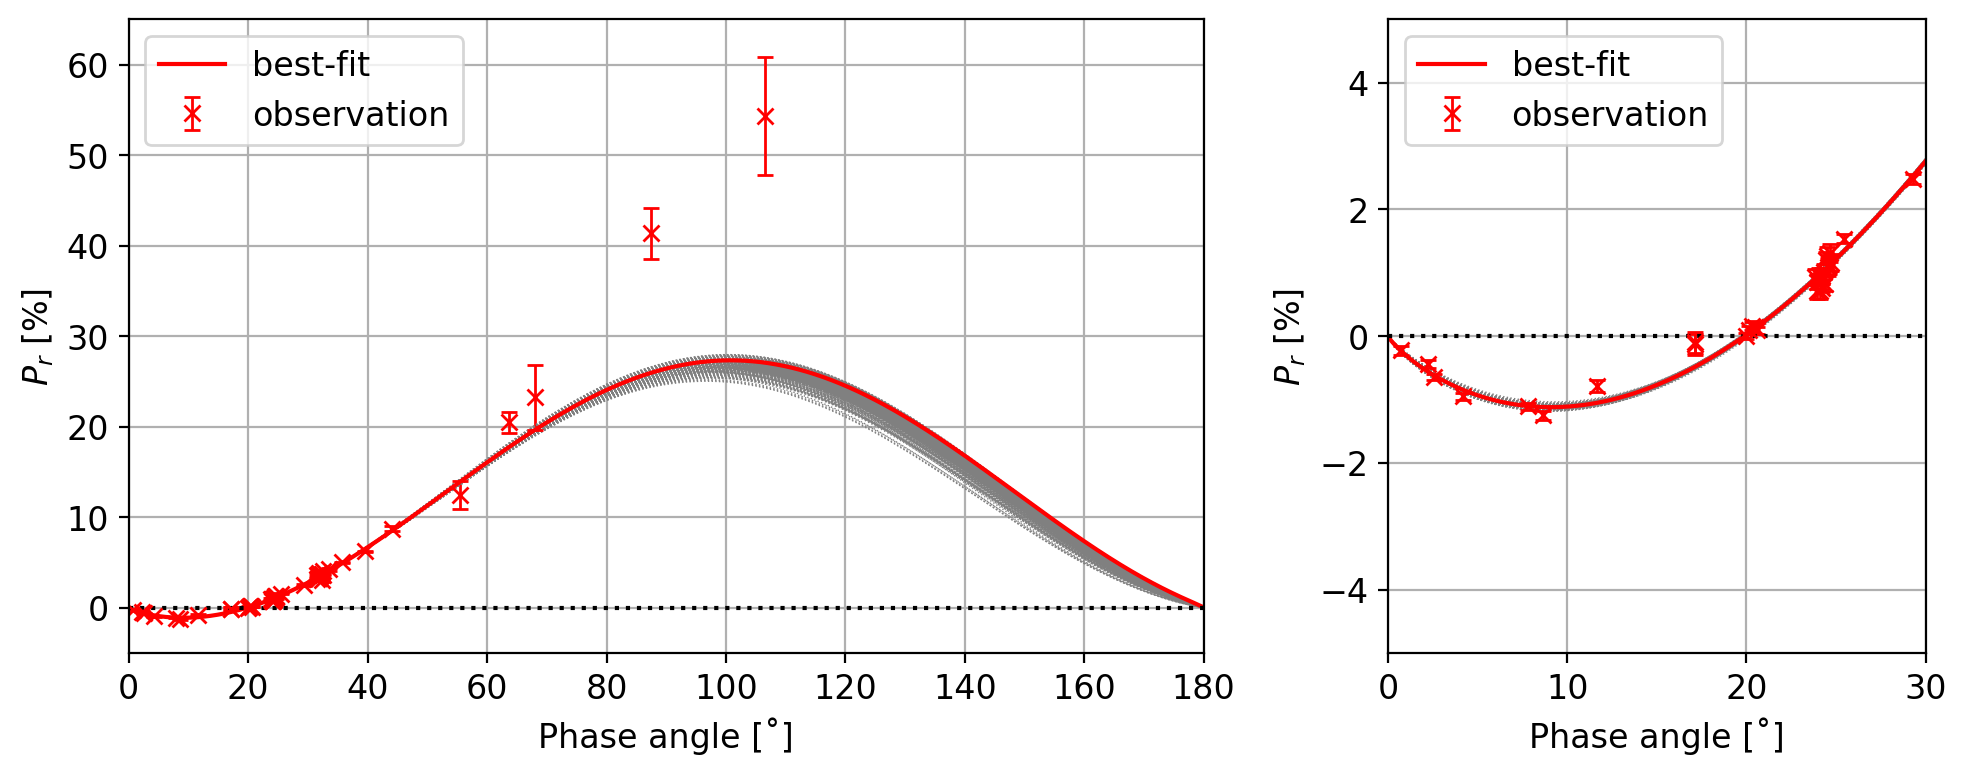

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=False, 
                        gridspec_kw={'width_ratios':[2,1]})

majloc = [MultipleLocator(30), MultipleLocator(10)]
minloc = [MultipleLocator(10), MultipleLocator(2)]
majfmt = [FormatStrFormatter("%d"), FormatStrFormatter("%d")]


for ax in axs.tolist():
    for j in range(0, n_trace, 200):
        ax.plot(xx, trigp_purepython(xx, res["h"][j], res["c1"][j], res["c2"][j], res["a0"][j]), 
                 ls=':', lw=0.5, color='grey')

    ax.errorbar(x, y, yerr, marker='x', elinewidth=1, capsize=3, color='r', ls='',
                label="observation")
    ax.plot(xx, trigp_purepython(xx, *popt), color='r', label="best-fit")

    ax.set_xlabel("Phase angle [˚]")
    ax.set_ylabel(r"$ P_r $ [%]")
    ax.legend(loc=2)
    ax.axhline(0, color='k', ls=':')

#     for i, aa in enumerate([ax.xaxis, ax.yaxis]):
#         aa.set_major_locator(majloc[i])
#         aa.set_minor_locator(minloc[i])
#         aa.set_major_formatter(majfmt[i])
    ax.grid(which='major', ls='-')
    ax.grid(which='minor', ls=':')

axs[0].set_xlim(0, 180)
axs[0].set_ylim(-5, 65)
axs[1].set_xlim(0, 30)
axs[1].set_ylim(-5, 5)



plt.tight_layout()
plt.savefig(SAVEPATH / "with-Devogele-revised-observation-mcmc.png", dpi=300)
plt.savefig(SAVEPATH / "with-Devogele-revised-observation-mcmc.pdf")

### 4-5. Pairplot of Parameters

Draw a corner plot

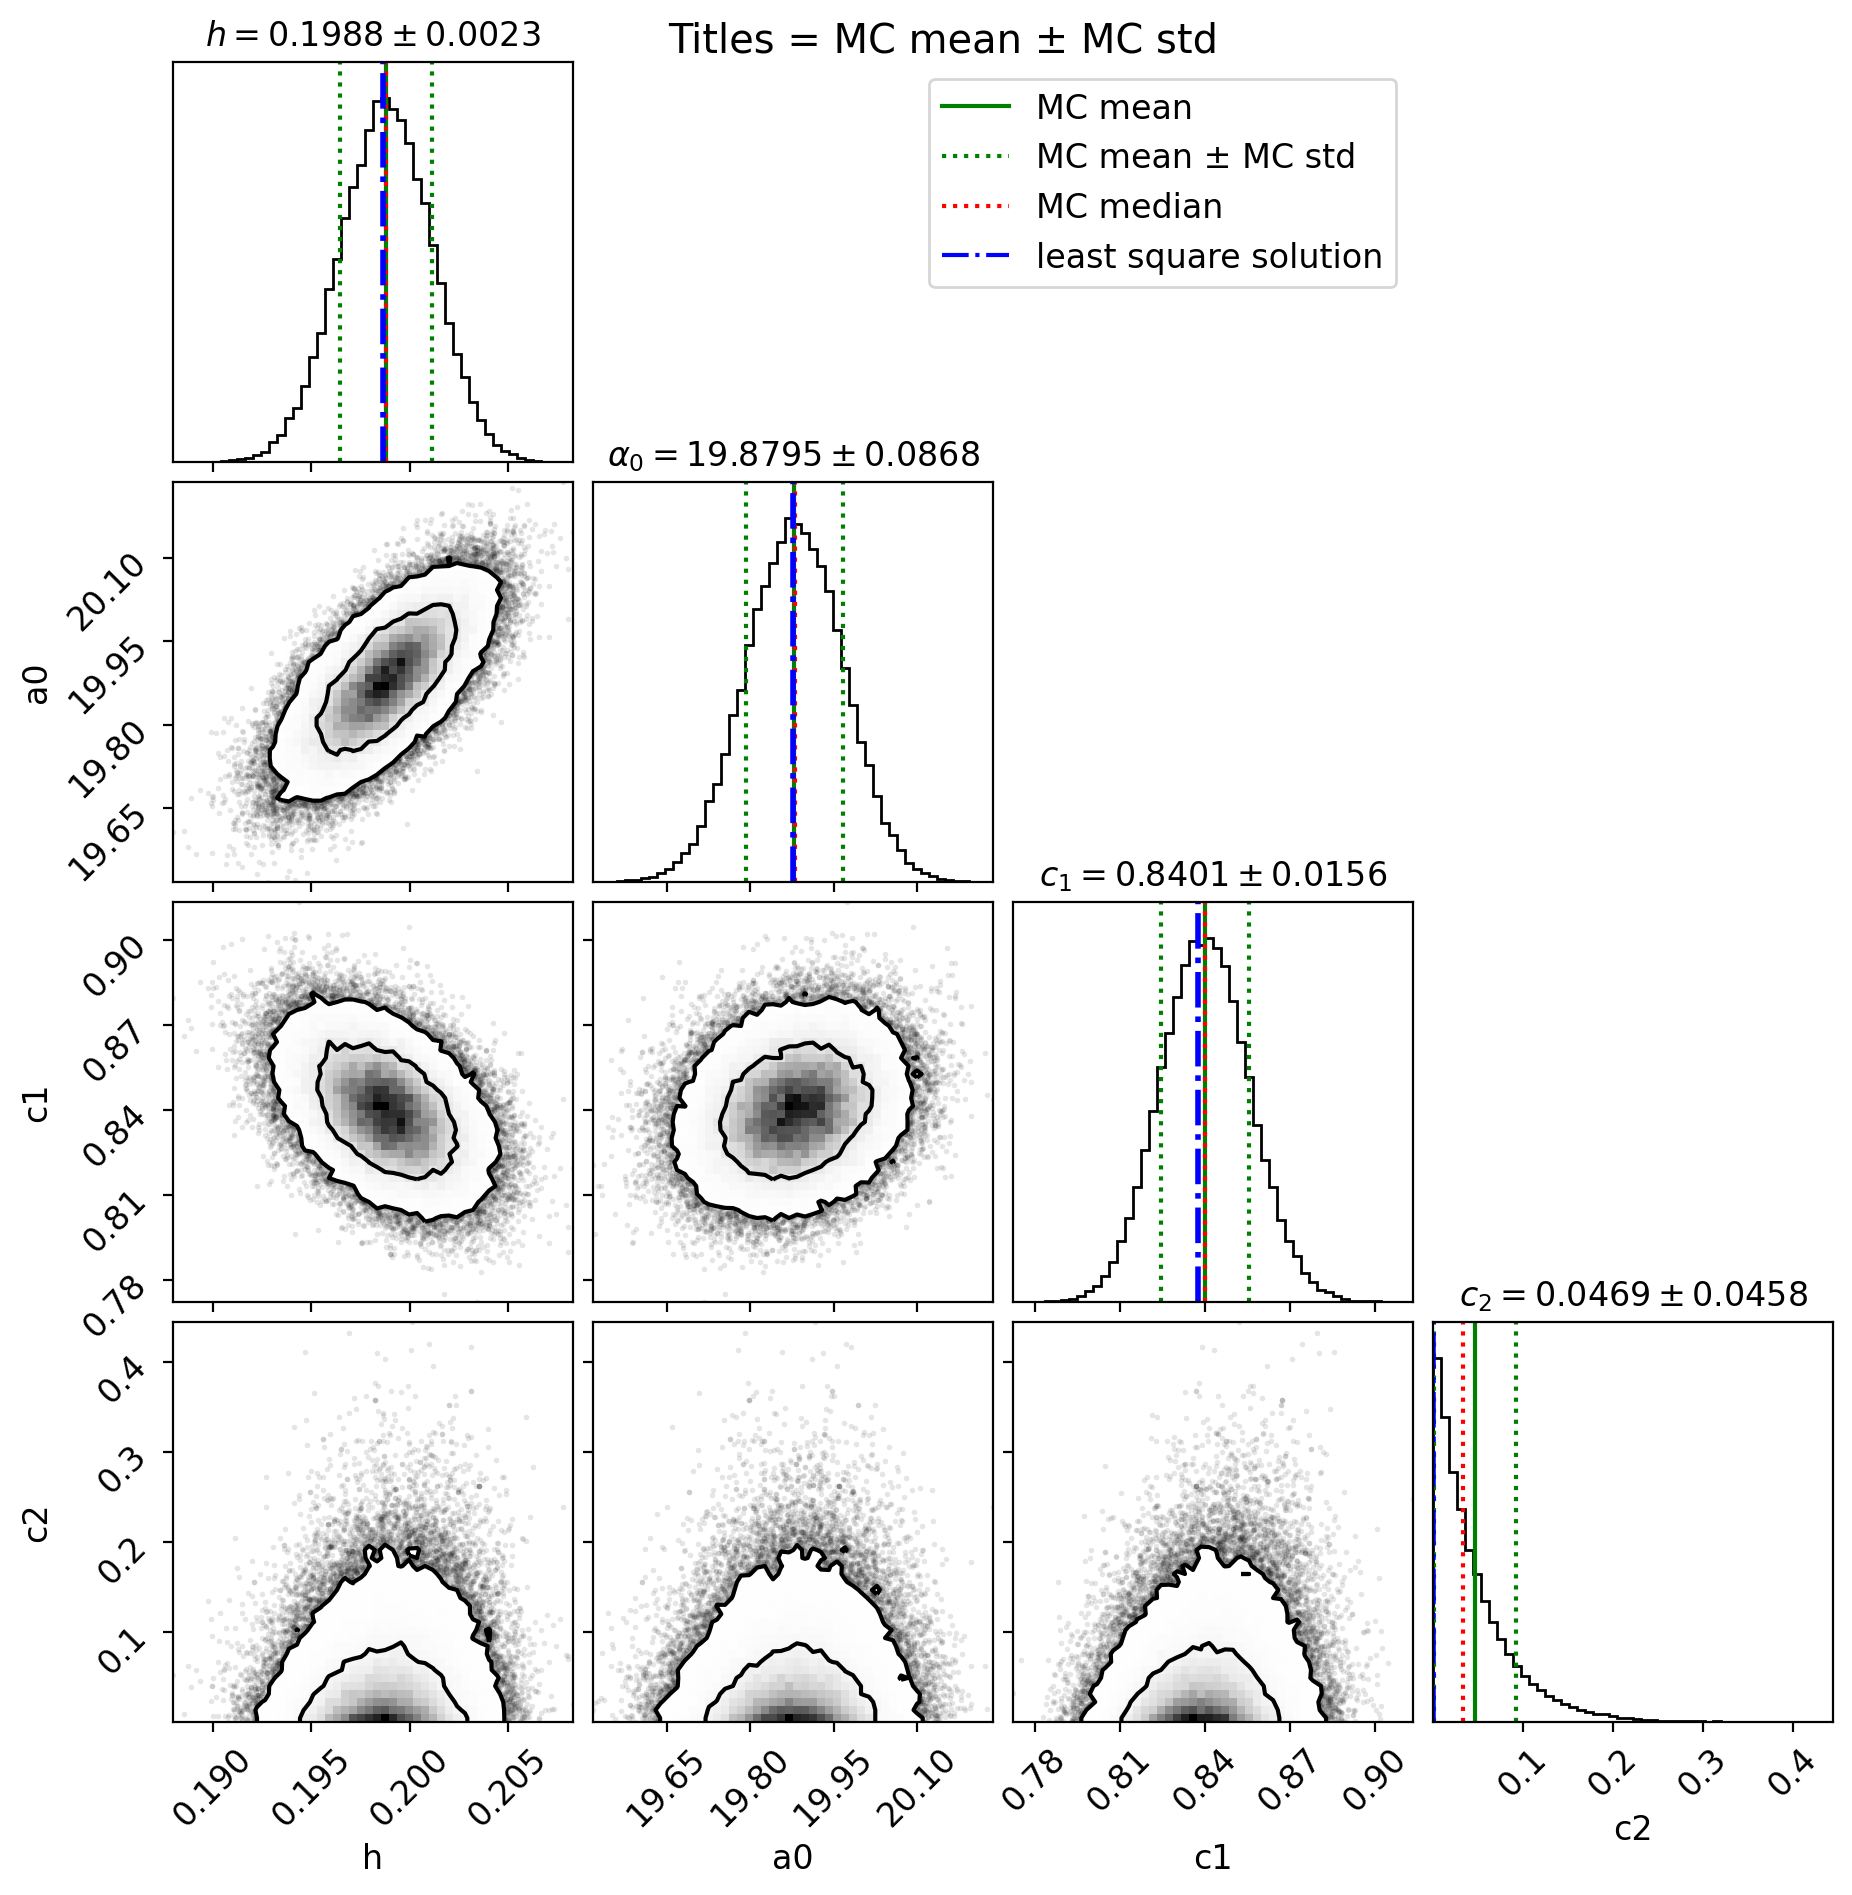

In [19]:
trace_df = pm.trace_to_dataframe(trace)
means = np.mean(trace_df, axis=0)
meds = np.median(trace_df, axis=0)
sds = np.std(trace_df, axis=0, ddof=1)
maps = np.array([popt[0], popt[3], popt[1], popt[2]])
varnames = dict(h='h', a0='\\alpha_0', c1='c_1', c2='c_2')

fig = corner.corner(trace_df, 
#                     quantiles=[0.5 - 0.6827/2, 0.5 + 0.6827/2],
                    levels=[0.6827, 0.9545], #, 0.9973
                    bins=50,
                    show_titles=False,
                    title_fmt='5.3f',
                    title_kwargs={'fontsize': 12}
                   )
axes = np.array(fig.axes).reshape((4, 4))

# Loop over the diagonal
for i in range(4):
    ax = axes[i, i]
    ax.axvline(means[i], color="g", ls='-')
    ax.axvline(means[i] - sds[i], color="g", ls=':')
    ax.axvline(means[i] + sds[i], color="g", ls=':')
    ax.axvline(meds[i], color="r", ls=':')
    ax.axvline(maps[i], color='b', ls='-.', lw=2)
    ax.set_title(r"${} = {:4.4f} \pm {:4.4f}$".format(varnames[trace.varnames[4+i]],
                                                     means[i],
                                                     sds[i]
                                                    ),
                fontsize=12)

axes[0, 2].plot(np.nan, np.nan, 'g-', label='MC mean')
axes[0, 2].plot(np.nan, np.nan, 'g:', label='MC mean ± MC std')
axes[0, 2].plot(np.nan, np.nan, 'r:', label='MC median')
# axes[0, 2].plot(np.nan, np.nan, 'k--', label='MC 1-$\sigma$ percentile')
axes[0, 2].plot(np.nan, np.nan, 'b-.', label='least square solution')
axes[0, 2].legend()
        
fig.suptitle("Titles = MC mean ± MC std")
plt.savefig(SAVEPATH/"with-Devogele-revised-corner.pdf")
plt.savefig(SAVEPATH/"with-Devogele-revised-corner.png", dpi=300)

You may use ``seaborn`` which is extremely slow in this case:
```python
trace_df = pm.trace_to_dataframe(trace)
# sns.pairplot(,
#              kind='reg', markers='+')

g = sns.PairGrid(trace_df, diag_sharey=False)
g.map_lower(sns.kdeplot, kind='reg')
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3)
```

### 4-6. To LATEX Table
If you want to save the resulting table as LaTeX format, for example, you may use the following python code:

In [20]:
tab_ls = param_tab[["pars", "lsqs", "plus", "minus"]].set_index("pars").T
tab_ls = tab_ls.set_index([[0, 1, 2], ["LS", "$ + $", "$ - $"]])

tab_mc = res_df.describe().loc[["mean", "std"]]
tab_mc = tab_mc.drop(columns="chi2")
tab_mc = tab_mc.set_index([[0, 1], ["MC", "sd"]])

tab = pd.concat([tab_ls, tab_mc], axis=0)
tab = tab.reset_index().drop(columns="level_0")
tab = Table.from_pandas(tab)
tab.rename_column("a0", "tmp_a0")
tab.add_column(tab["tmp_a0"], name="a0", index=2)
tab.remove_column("tmp_a0")

for c in tab.colnames:
    try:    
        tab[c].format = '.4f'
    except ValueError:
        continue

tabpath = SAVEPATH / "tab_with-Devogele-revised_bound.tex"
tab.write(tabpath, format='ascii.latex', latexdict=latexdicts["AA"])

lines = np.loadtxt(tabpath, delimiter='\t', dtype=bytes).astype(str)[5:-3]
[print(line) for line in lines];

LS & 0.1986 & 19.8766 & 0.8376 & 0.0001 & 9.0800 & -1.1209 & 100.8000 & 27.3301 \\
$ + $ & 0.0049 & 0.1819 & 0.0332 & 0.1079 & 0.2200 & 0.0500 & 0.1800 & 0.7419 \\
$ - $ & 0.0049 & 0.1830 & 0.0318 & 0.0000 & 0.2300 & 0.0505 & 1.9300 & 1.1989 \\
MC & 0.1988 & 19.8795 & 0.8401 & 0.0469 & 9.0904 & -1.1207 & 99.9563 & 26.8792 \\
sd & 0.0023 & 0.0868 & 0.0156 & 0.0458 & 0.1054 & 0.0243 & 0.8025 & 0.5529 \\


``latexdicts["AA"]`` means it is in the format of A&A. You may use ``"AA"``, ``"doublelines"``, and ``"template"``.

You may tune it as you wish...

## 5. What if no bound for powers?

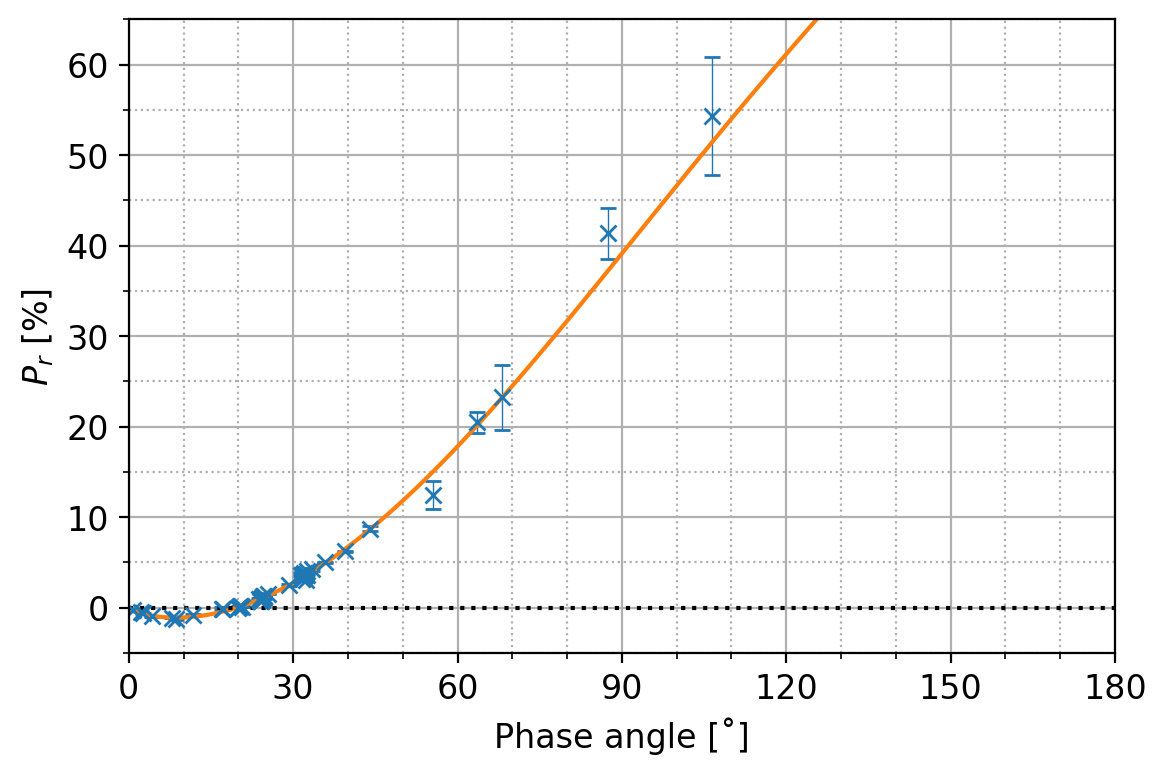

In [21]:
x, y, yerr = dats["PA"].to_numpy(), dats["Pr"].to_numpy(), dats["err_Pr"].to_numpy()
x_rad = D2R * x
xx = np.arange(0.1, 180, 0.1)

popt, pcov = curve_fit(trigp_purepython, x, y, sigma=yerr, p0=[1, 1, 1, 20],
                       absolute_sigma=True,
                       bounds=((0.01, -10., -10., 10),
                               (10.0, 10.0, 10.0, 30)))

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4), sharex=False, sharey=False, gridspec_kw=None)

majloc = [MultipleLocator(30), MultipleLocator(10)]
minloc = [MultipleLocator(10), MultipleLocator(5)]
majfmt = [FormatStrFormatter("%d"), FormatStrFormatter("%d")]

ax1 = plt.subplot(1, 1, 1)
ax1.errorbar(x, y, yerr, **errbfmt)
ax1.plot(xx, trigp_purepython(xx, *popt))

ax1.set_xlabel("Phase angle [˚]")
ax1.set_ylabel(r"$ P_r $ [%]")
ax1.set_xlim(0, 180)
ax1.set_ylim(-5, 65)
ax1.axhline(0, color='k', ls=':')

for i, aa in enumerate([ax1.xaxis, ax1.yaxis]):
    aa.set_major_locator(majloc[i])
    aa.set_minor_locator(minloc[i])
    aa.set_major_formatter(majfmt[i])
ax1.grid(which='major', ls='-')
ax1.grid(which='minor', ls=':')
plt.tight_layout()

plt.savefig(SAVEPATH / "with-Devogele-revised-observation-fit-nobound.png")
plt.savefig(SAVEPATH / "with-Devogele-revised-observation-fit-nobound.pdf")

In [22]:
x, y, yerr = dats["PA"].to_numpy(), dats["Pr"].to_numpy(), dats["err_Pr"].to_numpy()
x_rad = D2R * x
xx = np.arange(0.1, 180, 0.1)

popt, pcov = curve_fit(trigp_purepython, x, y, sigma=yerr, 
                       p0=[1, 1, 1, 20],
                       absolute_sigma=True,
                       bounds=((0.01, -10., -10., 10),
                               (10.0, 10.0, 10.0, 30)))
print("Least Square Fit with Scipy curve_fit\n")
print("h[%/˚]  c1      c2      a0[˚]")
print(f"{popt[0]:.4f}  {popt[1]:.4f}  {popt[2]:.4f}  {popt[3]:.4f}\n")

print("Elliptical Approximation Errors of above")
print("{:.4f}  {:.4f}  {:.4f}  {:.4f}\n".format(*np.sqrt(np.diag(pcov))))

amin, Pmin = trigp_min(np.arange(0, 20, 0.01), *popt)
amax, Pmax = trigp_max(np.arange(80, 130, 0.01), *popt)
print("amin[˚]  Pmin[%]  amax[˚]  Pmax[%]")
print(f"{amin:.2f}     {Pmin:.2f}    {amax:.2f} {Pmax:.2f}")

Least Square Fit with Scipy curve_fit

h[%/˚]  c1      c2      a0[˚]
0.1916  0.7728  -1.4825  19.7161

Elliptical Approximation Errors of above
0.0024  0.0175  0.1923  0.0926

amin[˚]  Pmin[%]  amax[˚]  Pmax[%]
8.67     -1.11    129.98 68.05


In [23]:
basic_model = pm.Model()
with basic_model:
    h = pm.Uniform('h', 0, 1)
    a0 = pm.Uniform('a0', 10, 35)
    c1 = pm.Uniform('c1', -10, 10)
    c2 = pm.Uniform('c2', -10, 10)

    sigma = theano.shared(np.asarray(yerr, dtype=theano.config.floatX), name='sigma')

    Y_hat = (h / D2R 
             * (sin(x * D2R) / sin(a0 * D2R))**c1 
             * (cos(x * D2R / 2) / cos(a0 * D2R / 2))**c2 
             * sin( (x - a0) * D2R)
            )
    liklihood = pm.Normal('likelihood', mu=Y_hat, sd=sigma, observed=y)

    trace = pm.sample(20000, start=dict(h=0.1, a0=20, c1=0.1, c2=1.e-3))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c2, c1, a0, h]
Sampling 4 chains, 0 divergences: 100%|██████████| 82000/82000 [00:49<00:00, 1665.05draws/s]
The acceptance probability does not match the target. It is 0.8803636131341114, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8855315100607457, but should be close to 0.8. Try to increase the number of tuning steps.


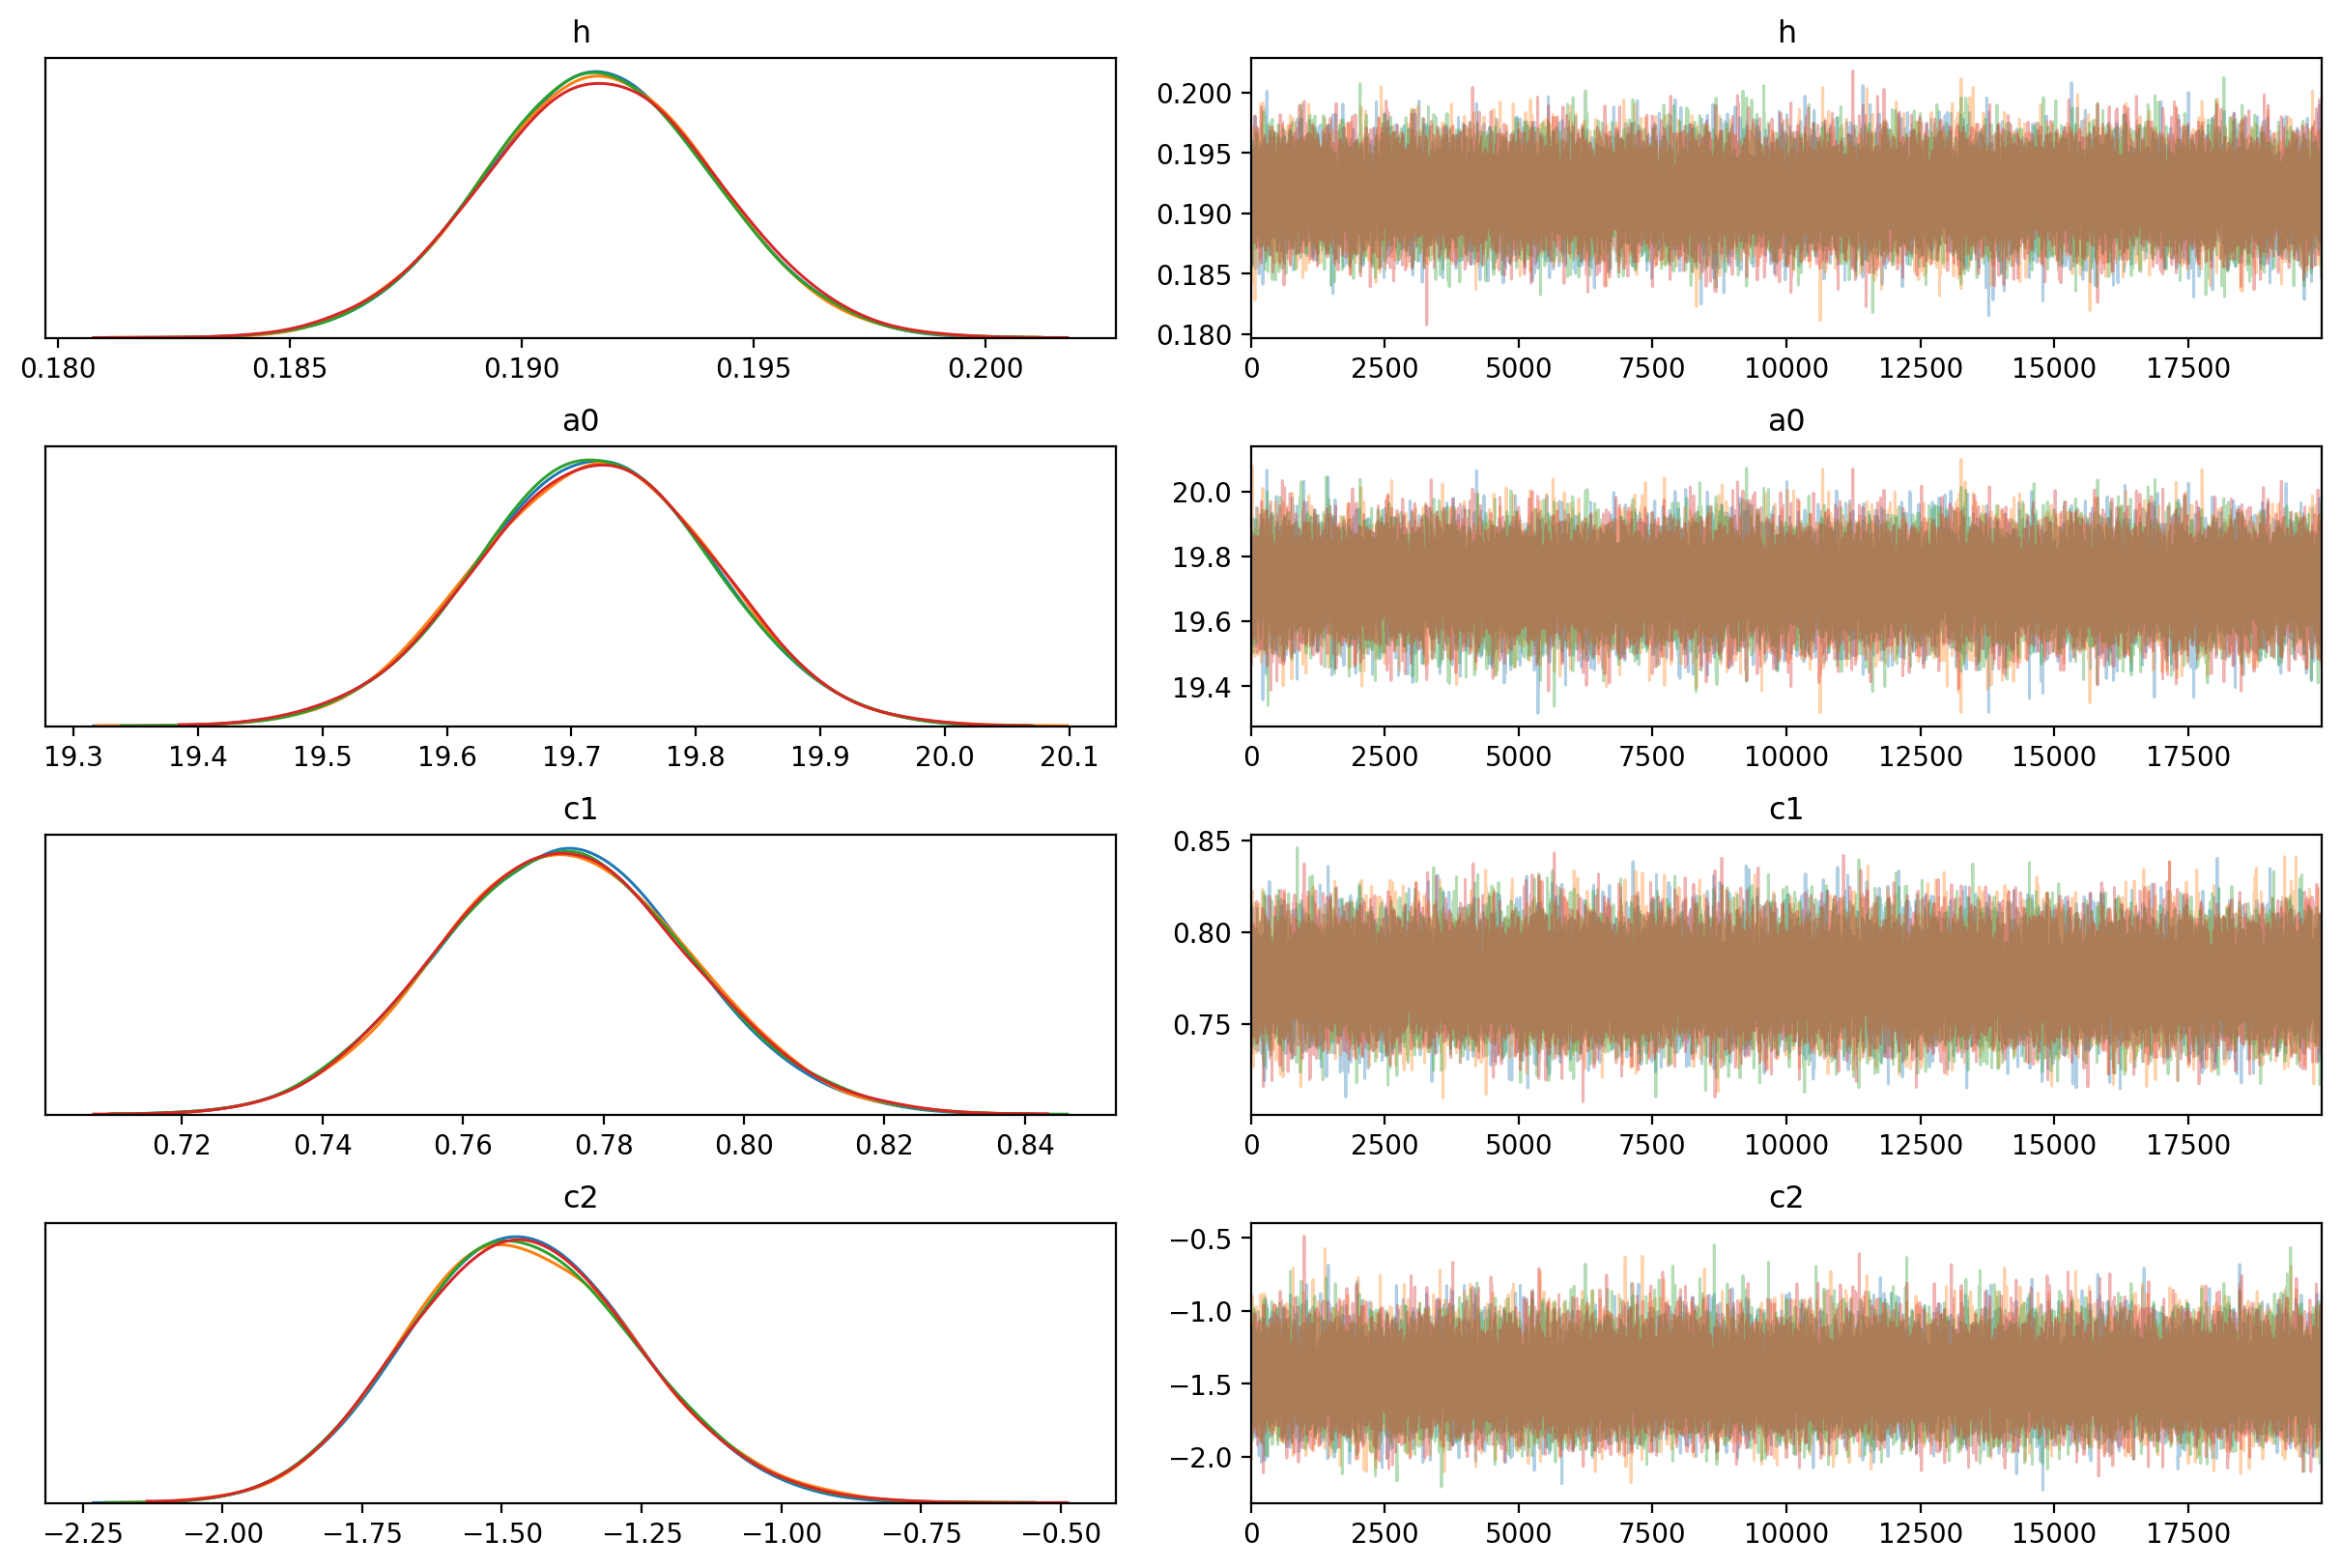

In [24]:
pm.traceplot(trace)
plt.savefig(SAVEPATH / "with-Devogele-revised-trace-nobound.png", dpi=300)
plt.savefig(SAVEPATH / "with-Devogele-revised-trace-nobound.pdf")

In [25]:
pm.summary(trace, credible_interval=0.6827).round(5)

,mean,sd,hpd_15.865%,hpd_84.135%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
h,0.192,0.002,0.189,0.194,0.000,0.000,35700.0,35700.0,35706.0,40212.0,1.0
a0,19.717,0.093,19.624,19.810,0.000,0.000,36028.0,36028.0,36062.0,42018.0,1.0
c1,0.774,0.018,0.755,0.790,0.000,0.000,38641.0,38582.0,38677.0,42326.0,1.0
c2,-1.464,0.202,-1.674,-1.270,0.001,0.001,37852.0,37852.0,37965.0,42953.0,1.0


In [26]:
pm.summary(trace, credible_interval=0.9973).round(5)  # 3-sigma

,mean,sd,hpd_0.135%,hpd_99.865%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
h,0.192,0.002,0.184,0.199,0.000,0.000,35700.0,35700.0,35706.0,40212.0,1.0
a0,19.717,0.093,19.432,19.994,0.000,0.000,36028.0,36028.0,36062.0,42018.0,1.0
c1,0.774,0.018,0.722,0.827,0.000,0.000,38641.0,38582.0,38677.0,42326.0,1.0
c2,-1.464,0.202,-2.048,-0.846,0.001,0.001,37852.0,37852.0,37965.0,42953.0,1.0


In [27]:
res = []
for h, a0, c1, c2 in zip(trace.get_values('h'),
                         trace.get_values('a0'),
                         trace.get_values('c1'),
                         trace.get_values('c2')):
    res.append(trigp_min(xx, h, c1, c2, a0))
res = np.array(res)
amin_mean, pmin_mean = np.mean(res, axis=0)
amin_sd, pmin_sd = np.std(res, axis=0, ddof=1)
print(f"a_min = {amin_mean:.4f} ± {amin_sd:.4f}")
print(f"P_min = {pmin_mean:.4f} ± {pmin_sd:.4f}")

a_min = 8.6780 ± 0.1282
P_min = -1.1082 ± 0.0235


In [28]:
n_param = 4
delta = chi2.ppf(0.6827, n_param)

n_trace = trace['h'].shape[0]
res = dict(h=trace['h'], c1=trace['c1'], c2=trace['c2'], a0=trace['a0'],
           chi2=np.zeros(n_trace),
           amax=np.zeros(n_trace), amin=np.zeros(n_trace),
           Pmax=np.zeros(n_trace), Pmin=np.zeros(n_trace))

do_trigp(x, y, yerr, 
         arr_h=res["h"], arr_c1=res["c1"], arr_c2=res["c2"], arr_a0=res["a0"], 
         arr_chi2=res["chi2"],
         arr_amax=res["amax"], arr_Pmax=res["Pmax"], 
         arr_amin=res["amin"], arr_Pmin=res["Pmin"])

chi2_min = res["chi2"].min()
mask_1sig = res["chi2"] < (chi2_min + delta)
# mask_1sig = res["chi2"] < (chi2_min + np.sqrt(2/(y.shape[0]-4)))

res_df = pd.DataFrame(res)
res_1sig = res_df[mask_1sig]

res_1sig.describe().loc[["min", "max"]]

,h,c1,c2,a0,chi2,amax,amin,Pmax,Pmin
min,0.186477,0.736602,-1.875727,19.517928,223.496597,133.46,8.41,47.628159,-1.158536
max,0.196787,0.810656,-1.025893,19.912805,228.216039,139.98,8.93,111.561564,-1.058526


In [29]:
res_df.describe()

,h,c1,c2,a0,chi2,amax,amin,Pmax,Pmin
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,0.191611,0.774063,-1.464097,19.716609,227.528791,139.698674,8.677956,75.021959,-1.108167
std,0.002427,0.017583,0.202133,0.093228,2.848623,1.648874,0.124876,15.090358,0.023504
min,0.180775,0.707402,-2.230766,19.316139,223.496597,111.590000,8.190000,34.017005,-1.198820
25%,0.189970,0.762003,-1.603079,19.653796,225.429765,139.980000,8.590000,64.174911,-1.124183
50%,0.191603,0.773951,-1.470382,19.717490,226.891657,139.980000,8.680000,73.963633,-1.108175
75%,0.193247,0.785834,-1.329103,19.779941,228.927087,139.980000,8.760000,84.550879,-1.092262
max,0.201760,0.846074,-0.487830,20.098386,249.602699,139.980000,9.180000,156.128773,-1.009294


In [30]:
param_tab = dict(pars=["h", "c1", "c2", "a0", "amin", "Pmin", "amax", "Pmax"],
                 lsqs=[*popt, amin, Pmin, amax, Pmax],  # least-square solution
                 plus=[], minus=[],  # mins/maxs in lsqs +/- sense
                 mins=[], maxs=[]    # min/max of 1-sigma range
                )
for i, p in enumerate(param_tab["pars"]):
    pmin = res_1sig[p].min()
    pmax = res_1sig[p].max()
    p_hi = abs(pmax - param_tab["lsqs"][i])
    p_lo = abs(param_tab["lsqs"][i] - pmin)
    
    param_tab["mins"].append(pmin)
    param_tab["maxs"].append(pmax)
    param_tab["plus"].append(p_hi)
    param_tab["minus"].append(p_lo)
    
param_tab = pd.DataFrame.from_dict(param_tab)
param_tab

,pars,lsqs,plus,minus,mins,maxs
0,h,0.191591,0.005197,0.005114,0.186477,0.196787
1,c1,0.772850,0.037806,0.036248,0.736602,0.810656
2,c2,-1.482456,0.456563,0.393272,-1.875727,-1.025893
3,a0,19.716103,0.196702,0.198175,19.517928,19.912805
4,amin,8.670000,0.260000,0.260000,8.410000,8.930000
5,Pmin,-1.108591,0.050066,0.049944,-1.158536,-1.058526
6,amax,129.980000,10.000000,3.480000,133.460000,139.980000
7,Pmax,68.052977,43.508587,20.424817,47.628159,111.561564


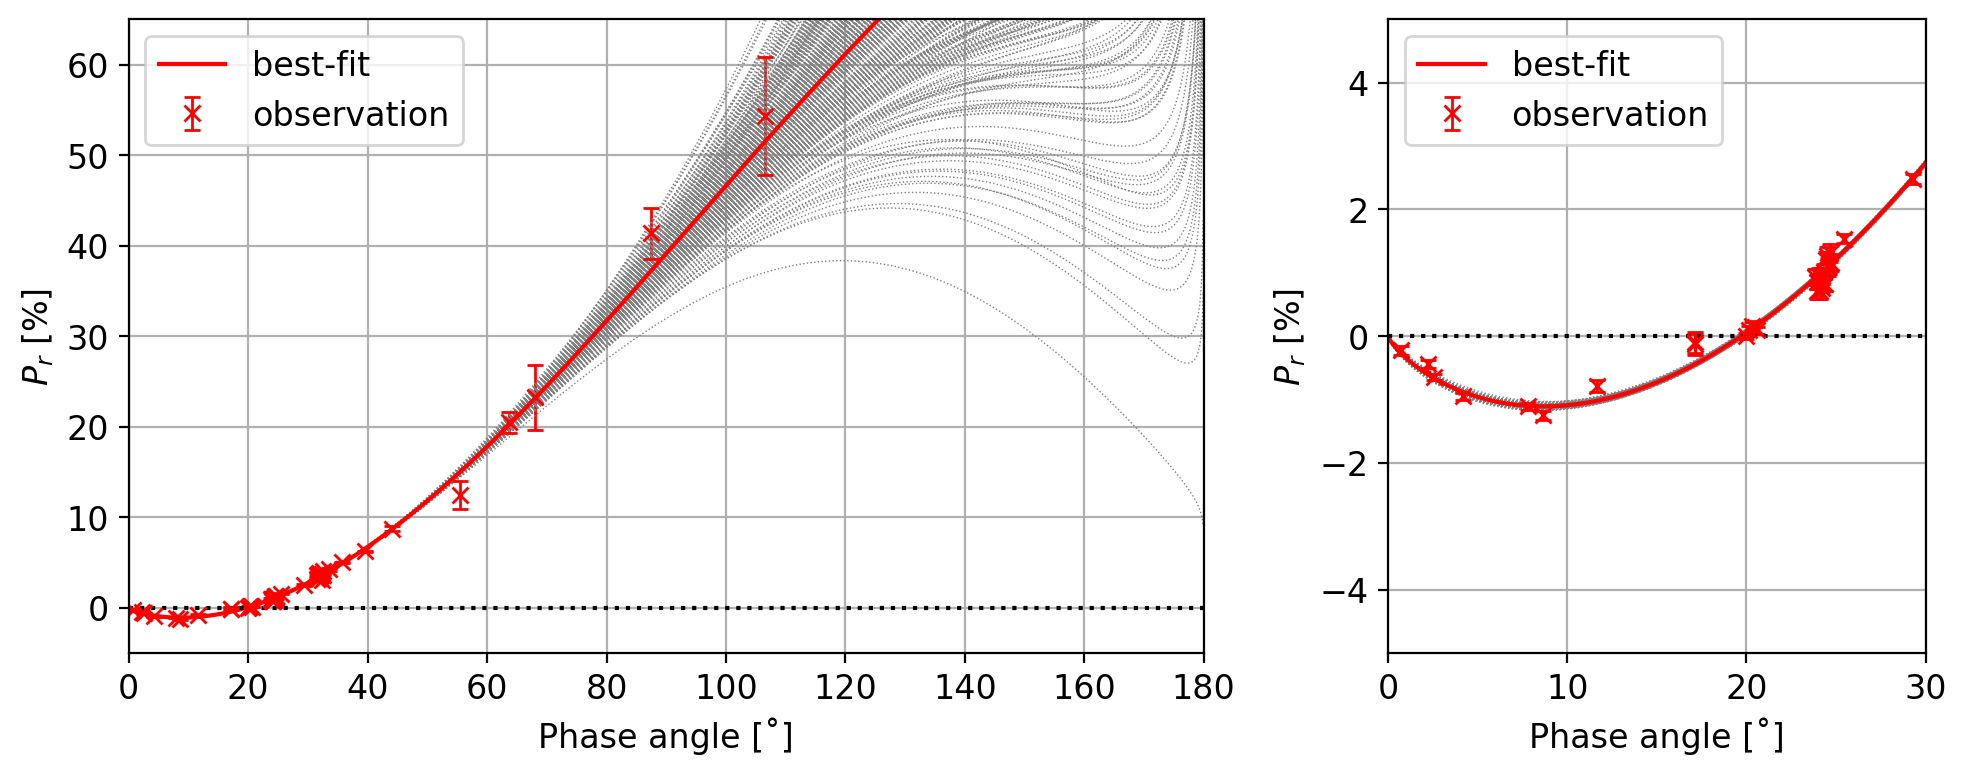

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=False, 
                        gridspec_kw={'width_ratios':[2,1]})

majloc = [MultipleLocator(30), MultipleLocator(10)]
minloc = [MultipleLocator(10), MultipleLocator(2)]
majfmt = [FormatStrFormatter("%d"), FormatStrFormatter("%d")]


for ax in axs.tolist():
    for j in range(0, n_trace, 200):
        ax.plot(xx, trigp_purepython(xx, res["h"][j], res["c1"][j], res["c2"][j], res["a0"][j]), 
                 ls=':', lw=0.5, color='grey')

    ax.errorbar(x, y, yerr, marker='x', elinewidth=1, capsize=3, color='r', ls='',
                label="observation")
    ax.plot(xx, trigp_purepython(xx, *popt), color='r', label="best-fit")

    ax.set_xlabel("Phase angle [˚]")
    ax.set_ylabel(r"$ P_r $ [%]")
    ax.legend(loc=2)
    ax.axhline(0, color='k', ls=':')

#     for i, aa in enumerate([ax.xaxis, ax.yaxis]):
#         aa.set_major_locator(majloc[i])
#         aa.set_minor_locator(minloc[i])
#         aa.set_major_formatter(majfmt[i])
    ax.grid(which='major', ls='-')
    ax.grid(which='minor', ls=':')

axs[0].set_xlim(0, 180)
axs[0].set_ylim(-5, 65)
axs[1].set_xlim(0, 30)
axs[1].set_ylim(-5, 5)



plt.tight_layout()
plt.savefig(SAVEPATH / "with-Devogele-revised-observation-mcmc-nobound.png", dpi=300)
plt.savefig(SAVEPATH / "with-Devogele-revised-observation-mcmc-nobound.pdf")

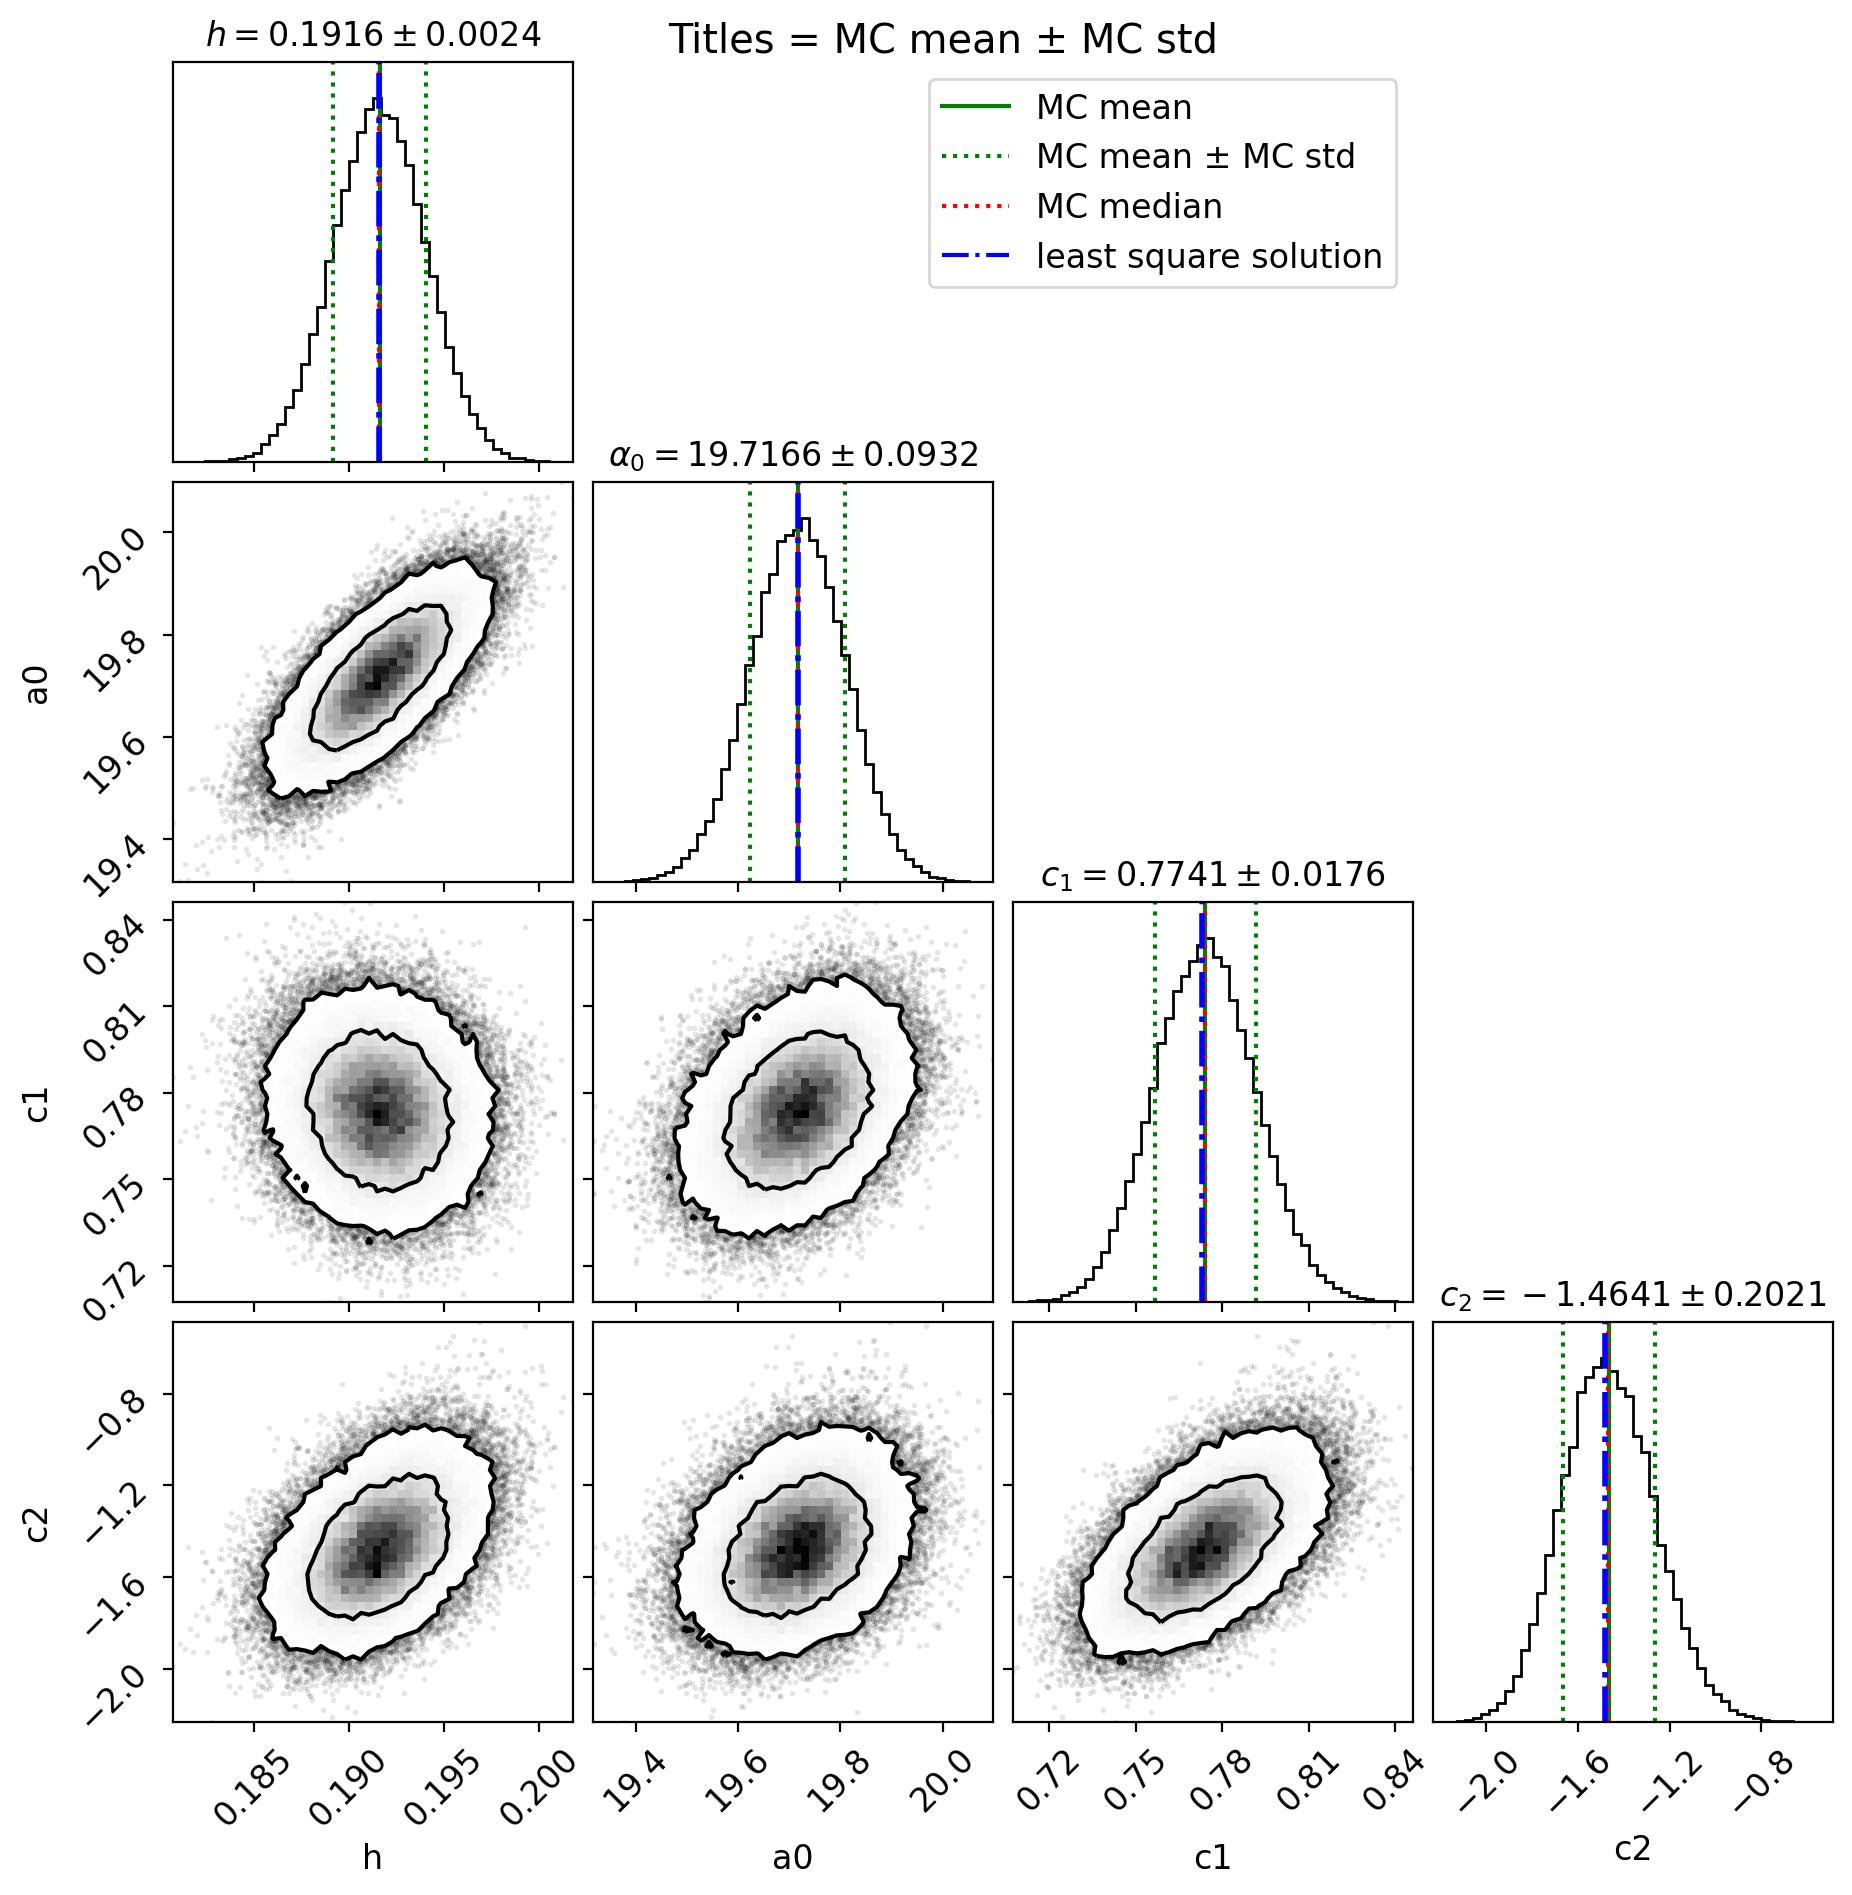

In [32]:
trace_df = pm.trace_to_dataframe(trace)
means = np.mean(trace_df, axis=0)
meds = np.median(trace_df, axis=0)
sds = np.std(trace_df, axis=0, ddof=1)
maps = np.array([popt[0], popt[3], popt[1], popt[2]])
varnames = dict(h='h', a0='\\alpha_0', c1='c_1', c2='c_2')

fig = corner.corner(trace_df, 
#                     quantiles=[0.5 - 0.6827/2, 0.5 + 0.6827/2],
                    levels=[0.6827, 0.9545], #, 0.9973
                    bins=50,
                    show_titles=False,
                    title_fmt='5.3f',
                    title_kwargs={'fontsize': 12}
                   )
axes = np.array(fig.axes).reshape((4, 4))

# Loop over the diagonal
for i in range(4):
    ax = axes[i, i]
    ax.axvline(means[i], color="g", ls='-')
    ax.axvline(means[i] - sds[i], color="g", ls=':')
    ax.axvline(means[i] + sds[i], color="g", ls=':')
    ax.axvline(meds[i], color="r", ls=':')
    ax.axvline(maps[i], color='b', ls='-.', lw=2)
    ax.set_title(r"${} = {:4.4f} \pm {:4.4f}$".format(varnames[trace.varnames[4+i]],
                                                     means[i],
                                                     sds[i]
                                                    ),
                fontsize=12)

axes[0, 2].plot(np.nan, np.nan, 'g-', label='MC mean')
axes[0, 2].plot(np.nan, np.nan, 'g:', label='MC mean ± MC std')
axes[0, 2].plot(np.nan, np.nan, 'r:', label='MC median')
# axes[0, 2].plot(np.nan, np.nan, 'k--', label='MC 1-$\sigma$ percentile')
axes[0, 2].plot(np.nan, np.nan, 'b-.', label='least square solution')
axes[0, 2].legend()
        
fig.suptitle("Titles = MC mean ± MC std")
plt.savefig(SAVEPATH/"with-Devogele-revised-corner-nobound.pdf")
plt.savefig(SAVEPATH/"with-Devogele-revised-corner-nobound.png", dpi=300)

In [33]:
tab_ls = param_tab[["pars", "lsqs", "plus", "minus"]].set_index("pars").T
tab_ls = tab_ls.set_index([[0, 1, 2], ["LS", "$ + $", "$ - $"]])

tab_mc = res_df.describe().loc[["mean", "std"]]
tab_mc = tab_mc.drop(columns="chi2")
tab_mc = tab_mc.set_index([[0, 1], ["MC", "sd"]])

tab = pd.concat([tab_ls, tab_mc], axis=0)
tab = tab.reset_index().drop(columns="level_0")
tab = Table.from_pandas(tab)
tab.rename_column("a0", "tmp_a0")
tab.add_column(tab["tmp_a0"], name="a0", index=2)
tab.remove_column("tmp_a0")

for c in tab.colnames:
    try:    
        tab[c].format = '.4f'
    except ValueError:
        continue

tabpath = SAVEPATH / "tab_with-Devogele-revised_unbound.tex"
tab.write(tabpath, format='ascii.latex', latexdict=latexdicts["AA"])

lines = np.loadtxt(tabpath, delimiter='\t', dtype=bytes).astype(str)[5:-3]
[print(line) for line in lines];

LS & 0.1916 & 19.7161 & 0.7728 & -1.4825 & 8.6700 & -1.1086 & 129.9800 & 68.0530 \\
$ + $ & 0.0052 & 0.1967 & 0.0378 & 0.4566 & 0.2600 & 0.0501 & 10.0000 & 43.5086 \\
$ - $ & 0.0051 & 0.1982 & 0.0362 & 0.3933 & 0.2600 & 0.0499 & 3.4800 & 20.4248 \\
MC & 0.1916 & 19.7166 & 0.7741 & -1.4641 & 8.6780 & -1.1082 & 139.6987 & 75.0220 \\
sd & 0.0024 & 0.0932 & 0.0176 & 0.2021 & 0.1249 & 0.0235 & 1.6489 & 15.0904 \\


In [34]:
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was finished at {now} ")

This notebook was finished at 2021-01-29 18:38:57 (KST = GMT+0900) 
